## load package

In [1]:
# load package
# string 
import re

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# sys
import sys
import os
import time
import warnings

# date
from datetime import datetime, timedelta

# math
import math

# preprocessing
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# apriori
from efficient_apriori import apriori

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# memory manage
import gc

# logging
import logging 

# other
import tqdm as tqdm

# self define
sys.path.append('../../utils/')

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# for network design
import torch
import argparse
import os

from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

In [3]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler = logging.FileHandler('../log/extract_features.log')
handler.setLevel(logging.INFO)
formater = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formater)
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.info('This is a log info')

2018-11-28 09:19:41,748 - __main__ - INFO - This is a log info


In [12]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()

d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# for training we use data from 14 - 17 in lb_wsp
train1 = pd.concat([d1,d2,d3,d4,d5], 0)
train2 = pd.concat([d6,d7,d8,d9,d10], 0)
train1['Autohaus'] = 'leonberg'
train2['Autohaus'] = 'weil'
#train = pd.concat([train1, train2], 0)
#train = train1.copy()

In [14]:
# because there exists reused Auftragsnummer in different Autohaus station. So we add some sign to the Auftragsnummer
# in each Autohaus station
train1['Auftragsnummer'] = 'A' + train1['Auftragsnummer']
train2['Auftragsnummer'] = 'B' + train2['Auftragsnummer']
train = pd.concat([train1, train2], 0)

## extract Teile-Gruppe
An 4 . Stelle der Teile-Nr ist die Baugruppe 
- 1 - Motor
- 2 - Kraftstoff, Abgas, Kühlung
- 3 - Getrieb
- 4 - Vorderachse, Lenkung
- 5 - Hinterachse
- 6 - Räder
- 7 - Hebelwerk
- 8 - Karosserie
- 9 - Elektrik
- 0 - Zubehör, Infotainment, Sonstiges

#### remove the outlier in the Teile-Nr
- na wert
- Teile-Nr, which length smaller than 4
- doesn't contain number??
- doesn't contain adjoining number 

Question: The Gruppe-Nr can also in the 5. stelle<br>
#df[df['Teile-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', x[3])))]['Teile-Nr']<br>
the command show the Teile-Nr, which type are not number. We can see that many Teile-Nr doesn't contrain number; some Teile-Nr contain number, however there are not in the 4. stelle bu in the 5. oder 6. stelle. Therefore we suggest that the first coming adjoining nummer in the Teile-Nr may be the gruppe-Nr.<br>
We extract the gruppe-Nr according to this idea.<br>
This phase takes train data as input and output Dataframe df

In [15]:
# remove the outlier in the Teile-Nr
# remove the na wert
df = train[train['Teile-Nr'].isna().map(lambda x: not x)]
# remove the value short value
df = df[df['Teile-Nr'].map(lambda x: False if len(x) < 4 else True)]
# remove the value that doesn't contain number: 30593 of 593527 in train1(5%)
df = df[df['Teile-Nr'].map(lambda x: True if re.search('\d', x) else False)]
# remove the value that doesn't contrain adjoining number(min 2 number): 594 of 562934 in train1(0.1%)
df = df[df['Teile-Nr'].map(lambda x: True if re.search('\d\d', x) else False)]

In [16]:
# use findall instead of search, because, the df here should contain adjoining number, otherwise it's wrong
df['Gruppe-Nr'] = df['Teile-Nr'].map(lambda x: re.findall('\d\d', x)[0][0])

In [17]:
df['Gruppe-Nr'].value_counts()

0    930093
1    281620
9    241658
3     46656
2     37419
6     23866
8     21086
5     19447
4     14385
7      6041
Name: Gruppe-Nr, dtype: int64

In [18]:
# clean the memory
del train1, train2, lb_wsp_2014, lb_wsp_2015, lb_wsp_2016, lb_wsp_2017, lb_wsp_2018
del std_wsp_2014, std_wsp_2015, std_wsp_2016, std_wsp_2017, std_wsp_2018
del d1, d2, d3, d4, d5, d6, d7, d8, d9, d10
gc.collect()

91

In [19]:
#

## remove the confused data
- For the same Auftragsnummer, exists more than one value in the other attribute.
- wierd Auftragsnummer: 107K, 77KW
- Fahrgestellnummer is Na
- Fahrgestellnummer that only contrain number.
- In Auftragsdatum, the day of the datum is larger than 31
- Wierd Auftragsdatum, these datum is shorter than 10 Ziffer.
- Wierd Auftragsdatum, these datum is smaller than 2013

In [20]:
# not only see that data with gruppe-nr == 9, 241658 items
# the target of next coming can also for the other thing, not the eletric
# df = df[df['Gruppe-Nr'] == '9']

In [21]:
# choose the features, which may be essentail to the model
# We will take care of the 'AW-Nr' and 'KM-Stand' in the other place.
# there are 98256 unique items in cf, more than 90423 items in af, which means they may create NA value after merging
#cf = train[['Auftragsnummer', 'AW-Nr', 'Markencode', 'Lagerortcode', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell', 'Typ',
#        'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Fahrgestellnummer']]
cf = df.copy()

In [22]:
# drop duplicate
cf = cf.drop_duplicates()

In [23]:
# find out the confused data. For the same Auftragsnummer, exists more than one value in the other attribute.
# here is AWSAU310019, BWSAU386471, BWSAU435051
cf = cf.drop(cf[cf['Auftragsnummer'] == 'AWSAU310019'].index, axis= 0) # 8 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU386471'].index, axis= 0) # 3 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU435051'].index, axis= 0) # 2 items
cf = cf.drop(cf[cf['Auftragsnummer'] == 'BWSAU271939'].index, axis= 0) # ? items

In [24]:
# remove wierd auftragsnummer
cf = cf.drop(cf[cf['Auftragsnummer'] == '103K'].index) #
cf = cf.drop(cf[cf['Auftragsnummer'] == '77KW'].index) #

In [25]:
# remove na value in Fahrgestellnummer
cf = cf.drop(cf[cf['Fahrgestellnummer'].isna()].index, axis = 0) #

In [26]:
# remove the Fahrgestellnumer that only contain number, not tested!!!!
cf = cf.drop(cf[cf['Fahrgestellnummer'].map(lambda x: False if re.search('[a-zA-Z]', x) else True)].index, axis = 0)

In [27]:
# remove the items, which day of the Auftragsdatum lareger than 31, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x: int(x[0:2])) > 31].index, axis = 0)

In [28]:
# remove the items, which length of the Auftragsdatum shorter than 10, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x:True if len(x) < 10 else False)].index, axis = 0)

In [29]:
# remove the items, which year of the Auftragsdatum smaller than 2013, not tested!!!!
cf = cf.drop(cf[cf['Auftragsdatum'].map(lambda x: int(x[6:]) < 2013)].index, axis = 0)

In [30]:
#len(cf)

In [31]:
df = cf
del cf
gc.collect()

168

In [32]:
#check_to_1(df, 'Fahrgestellnummer', 'Markencode')

In [33]:
#check_to_1(df, 'Fahrgestellnummer', 'Lagerortcode')

In [34]:
#check_to_1(df, 'Fahrgestellnummer', 'Adressanredecode')

In [35]:
#check_to_1(df, 'Fahrgestellnummer', 'Motorcode')

In [36]:
#check_to_1(df, 'Fahrgestellnummer', 'Fahrzeugmodellnummer')

In [37]:
#check_to_1(df, 'Fahrgestellnummer', 'Modell')

In [38]:
#check_to_1(df, 'Fahrgestellnummer', 'Typ')

In [39]:
#check_to_1(df, 'Fahrgestellnummer', 'Getriebecode')

In [40]:
#check_to_1(df, 'Fahrgestellnummer', 'Gewicht')

In [41]:
#check_to_1(df, 'Fahrgestellnummer', 'Leistung (KW)')

In [42]:
#check_to_1(df, 'Fahrgestellnummer', 'Fahrgestellnummer')

In [43]:
#check_to_1(train, 'Fahrgestellnummer', 'KM-Stand')

In [44]:
#check_to_1(train, 'Fahrgestellnummer', 'Erstzulassungsdatum')

## Get Auftrag table for Gruppe-Nr

In [45]:
gn = df.copy()

In [46]:
gn = toAuftragTable(gn, 'Gruppe-Nr', 'Auftragsnummer') # number: 245018

Falls Null date exist, drop these dates directly


In [47]:
len(gn)

244077

## extract feature: total AW-Nr
extract the feature total AW and combine aw with gruppe-nr auftragstable to form a new Dataframe agn. <br>
combine the attribute in df to the agn

In [48]:
aw = train.copy() # can't use df here, because df delete all the na value in Teile-Nr

In [49]:
# remove the items, that contain ziffer in the AW-Nr, set data type to int
aw['AW-Nr'][aw['AW-Nr'].isnull()] = 0 # set null value to 0
aw['AW-Nr'][aw['AW-Nr'] == '99999999'] = 0 # set 99999999 to 0
aw['AW-Nr'] = aw['AW-Nr'].map(lambda x: re.sub(' ', '', str(x)))# remove space between the number
del_index = aw[aw['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))].index # remove fake data
aw = aw.drop(del_index) 
aw['AW-Nr'] = aw['AW-Nr'].astype('float')

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
# to auftrag table, get the feature: total AW-Nr for each auftrag
tmp = aw[['AW-Nr', 'Auftragsnummer']]
ag = tmp.groupby('Auftragsnummer', as_index = False)
out = []
for name, gruppe in ag:
    out.append(pd.DataFrame({'Auftragsnummer': [gruppe['Auftragsnummer'].iloc[0]], 'total AW': [gruppe['AW-Nr'].sum()]}))
aw = pd.concat(out).reset_index()[['Auftragsnummer', 'total AW']] # 缺分段
# drop the wierd Auftragsnummer
aw = aw.drop(aw[aw['Auftragsnummer'] == '103K'].index)
aw = aw.drop(aw[aw['Auftragsnummer'] == '77KW'].index)

In [51]:
# the lengths of aw and gn are different, because in some auftrag, the customer do not buy anything. 
# These part of auftrags are not included in gn, but gn is not a subset of aw. 
# because some AW-Nr in aw are wrong, we have deleted these items in aw. 
# Therefore, if we want to merge aw and gn, we have to use the method inner
agn = pd.merge(aw, gn, how = 'inner', on = 'Auftragsnummer')

## extract feature: num_act
not tested jet<br>
make sure that, the length of the output, shoube be the same as the length of agn

In [52]:
aw = train.copy()
# remove the items, that contain ziffer in the AW-Nr, set data type to int
aw['AW-Nr'][aw['AW-Nr'].isnull()] = 0 # set null value to 0
aw['AW-Nr'][aw['AW-Nr'] == '99999999'] = 0 # set 99999999 to 0
aw['AW-Nr'] = aw['AW-Nr'].map(lambda x: re.sub(' ', '', str(x)))# remove space between the number
del_index = aw[aw['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))].index # remove fake data
aw = aw.drop(del_index) 
aw['AW-Nr'] = aw['AW-Nr'].astype('float')
# to auftrag table, get the feature: total AW-Nr for each auftrag
tmp = aw[['AW-Nr', 'Auftragsnummer']]
ag = tmp.groupby('Auftragsnummer', as_index = False)
out = []
for name, gruppe in ag:
    out.append(pd.DataFrame({'Auftragsnummer': [gruppe['Auftragsnummer'].iloc[0]], 'num_act': [len(gruppe)]}))
aw = pd.concat(out).reset_index()[['Auftragsnummer', 'num_act']] # 缺分段
# drop the wierd Auftragsnummer
aw = aw.drop(aw[aw['Auftragsnummer'] == '103K'].index)
aw = aw.drop(aw[aw['Auftragsnummer'] == '77KW'].index)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [53]:
#agn = pd.merge(aw, agn, how = 'inner', on = 'Auftragsnummer')
agn = pd.merge(aw, agn, how = 'inner', on = 'Auftragsnummer')

In [54]:
agn.head()

,Auftragsnummer,num_act,total AW,Gruppe-Nr
0,AWSAU195981,31,1.526062e+09,0;3
1,AWSAU198256,31,6.398138e+08,0;9;1
2,AWSAU200129,14,3.832960e+08,0;6;9;1
3,AWSAU200223,60,1.841819e+09,6;0;5;3;1;9
4,AWSAU200258,23,5.367113e+08,0;9;1


In [55]:
#train[train['Auftragsnummer'] == 'AWSAU195981']

## extract feature: num_teile

In [56]:
agn['num_teile'] = agn['Gruppe-Nr'].map(lambda x: len(x.split(';')))

In [57]:
agn[['total AW', 'num_act']].corr() 
# why the correlation is so small??

,total AW,num_act
total AW,1.000000,0.584288
num_act,0.584288,1.000000


In [58]:
del aw, gn
gc.collect()

112

## combine agn with df

In [59]:
tmp = df[['Auftragsnummer', 'KM-Stand','Markencode', 'Lagerortcode', 'Auftragsdatum', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell', 'Typ', 
          'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Fahrgestellnummer', 'Erstzulassungsdatum']]
tmp = tmp.drop_duplicates()
tmp = pd.merge(agn, tmp, how = 'inner', on = 'Auftragsnummer') # 244608

In [60]:
df = tmp
del tmp
gc.collect()

41

In [61]:
#TODO
# calculate the length of aw and original df
# i suggest that, because i delete all the na value in Teile-Nr, the number of items in original df is smaller
# than the number in aw.
# the result is, after mergin, there are many na value in some attribute, 
# i want to see the number of distance.
# or may be i can merge the data in the other direction: 'right'
# but mit direction right, there exist also 600 null value but in total AN, the reason may be
# that i delete some fake data in aw.
# the problem here is, should i maintain the na value in total AW, other just remove all of them?

In [62]:
#df[df['Fahrgestellnummer'] == 'WAUZZZ4M3GD004848'][['Fahrgestellnummer', 'Auftragsdatum', 'KM-Stand']]

## extract features: month, day

In [63]:
md = df.copy()
# remove the outlier in the data
#fake = md[md['Auftragsdatum'].map(lambda x:True if re.search('[a-zA-Z]', x) else False)]
#md = md.drop(fake.index, axis=0)

In [64]:
md['year'] = md['Auftragsdatum'].map(lambda x: x[6:])
md['month'] = md['Auftragsdatum'].map(lambda x: x[3:5])
md['day'] = md['Auftragsdatum'].map(lambda x: x[0:2])

In [65]:
df = md
del md
gc.collect()

28

In [66]:
df['num_teile'].value_counts()

1     99287
3     66428
2     50047
4     20344
5      5373
6      1446
7       494
8       185
9        53
10       10
Name: num_teile, dtype: int64

## extract feature: age
not tested jet!!!<br>
age_auto = auftragsdatum - Erstzulassungsdatum<br>
age_autohaus = auftragsdatum - 2013

In [67]:
#tmp = train[['Auftragsdatum', 'Erstzulassungsdatum']]
tmp = df.copy()

In [68]:
tmp['Auftragsdatum'] = pd.to_datetime(tmp['Auftragsdatum'], dayfirst=True)
tmp['Erstzulassungsdatum'] = pd.to_datetime(tmp['Erstzulassungsdatum'], dayfirst=True)
tmp['age_auto'] = tmp['Auftragsdatum'] - tmp['Erstzulassungsdatum']
tmp['age_auto'] = tmp['age_auto'].map(lambda x: x.days) % 365 # not test jet

In [69]:
tmp['age_autohaus'] = tmp['Auftragsdatum'].map(lambda x: x.year) - 2013

In [70]:
df = tmp
del tmp
gc.collect()

14

In [71]:
df.head(10)

,Auftragsnummer,num_act,total AW,Gruppe-Nr,num_teile,KM-Stand,Markencode,Lagerortcode,Auftragsdatum,Adressanredecode,Motorcode,Fahrzeugmodellnummer,Modell,Typ,Getriebecode,Gewicht,Leistung (KW),Fahrgestellnummer,Erstzulassungsdatum,year,month,day,age_auto,age_autohaus
0,AWSAU195981,31,1.526062e+09,0;3,2,"38110,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-13,Firma,CRBC,5G131X,Golf VII 2.0 TDI CL BMT,X0A,PFL,"0,00",110.0,WVWZZZAUZDP084627,2013-05-17,2014,01,13,241.0,1
1,AWSAU198256,31,6.398138e+08,0;9;1,3,"59660,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-16,AN,CJC,8K50SC,Audi A4 Attraction Avant 2.0 T,X0A,MVS,"0,00",0.0,WAUZZZ8K0DA098516,2012-07-27,2014,01,16,173.0,1
2,AWSAU200129,14,3.832960e+08,0;6;9;1,4,"227777,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-09,Herr,CBAB,5K143M,"Golf Highline 2,0 l",X0A,LQV,"0,00",0.0,WVWZZZ1KZAW187314,2009-11-25,2014,01,09,46.0,1
3,AWSAU200223,60,1.841819e+09,6;0;5;3;1;9,6,"65174,00",VW,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",2014-01-07,Herr,AXR,1J5134,VW Golf IV > 98 / Variant > 99,NaN,EUH,"0,00",0.0,WVWZZZ1JZ2W511716,2002-02-15,2014,01,07,329.0,1
4,AWSAU200258,23,5.367113e+08,0;9;1,3,"212110,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Firma,CAGA,8K50QC,A4 Avant 2.0 TDI Attraction,X0A,LLN,"0,00",105.0,WAUZZZ8K5AA164327,2010-05-06,2014,01,02,242.0,1
5,AWSAU200259,9,1.862719e+08,0;9,2,"91895,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,ALT,8E20B4,A4 Limousine 2.0 R4 96 M5S,NaN,GBM,"0,00",0.0,WAUZZZ8E13A363100,2003-04-24,2014,01,02,256.0,1
6,AWSAU200260,11,3.962096e+08,0,1,"122325,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,CAYC,8P1AE4,Audi A3 Attraction 3-Türer 1.6,X0A,LUB,"0,00",0.0,WAUZZZ8PXAA157479,2010-04-29,2014,01,02,249.0,1
7,AWSAU200263,36,6.978901e+08,0;9;3;1,4,"112386,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,ASB,4F20LL,Audi A6 Limousine 3.0 TDI (DPF,X0A,KGX,"0,00",0.0,WAUZZZ4F28N185258,2008-10-04,2014,01,02,91.0,1
8,AWSAU200264,12,1.656055e+08,0;3;8,3,"42783,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,CLAB,4G50NH,A6 Avant 3.0 TDI,X0A,NKP,"0,00",150.0,WAUZZZ4G4CN101295,2012-02-21,2014,01,02,316.0,1
9,AWSAU200269,8,1.641055e+08,0;3,2,"180999,00",AUDI,"Weeber Leonberg Audi (Glemseckstraße 39, 71229...",2014-01-02,Herr,BPP,8ED0YH,Audi A4 Avant 2.7 TDI(DPF),X0A,JBB,"0,00",0.0,WAUZZZ8E07A224307,2007-03-29,2014,01,02,281.0,1


## transfer the type of km stand to float

In [72]:
df['KM-Stand'] = df['KM-Stand'].map(lambda x: float(re.sub(',', '.', x)))

## extract feature: KM age

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243667 entries, 0 to 243666
Data columns (total 24 columns):
Auftragsnummer          243667 non-null object
num_act                 243667 non-null int64
total AW                243667 non-null float64
Gruppe-Nr               243667 non-null object
num_teile               243667 non-null int64
KM-Stand                243667 non-null float64
Markencode              243468 non-null object
Lagerortcode            243667 non-null object
Auftragsdatum           243667 non-null datetime64[ns]
Adressanredecode        241586 non-null object
Motorcode               235550 non-null object
Fahrzeugmodellnummer    243477 non-null object
Modell                  242305 non-null object
Typ                     162462 non-null object
Getriebecode            234752 non-null object
Gewicht                 243461 non-null object
Leistung (KW)           243461 non-null float64
Fahrgestellnummer       243667 non-null object
Erstzulassungsdatum     243461 non

## extract feature: num_visit

In [74]:
nv = df.copy()

In [75]:
tmp = nv[['Fahrgestellnummer', 'Auftragsdatum']]
tmp['num_visit'] = 1

out = []
for name, group in tmp.groupby('Fahrgestellnummer', as_index=False):
    out.append(group.sort_values('Auftragsdatum')['num_visit'].cumsum())

out = pd.concat(out, axis = 0)

nv = pd.concat([nv, out], axis = 1)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
df = nv
del nv, tmp
gc.collect()

291

## extract feature: Erstzulassungsdatum_year

In [77]:
df['Erstzulassungsdatum'][df['Erstzulassungsdatum'].map(lambda x: True if bool(re.search('[a-z]', str(x))) else False)] = 'unknown'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
df['Erstzulassungsdatum_year'] = df['Erstzulassungsdatum'].replace(['unknown'], '2012').map(lambda x: int(str(x)[:4]))

## extract feature: time relative
- times in group
- time distance since last come
- time distance to next come
- km stand distance since last come(correct the data first)
- km stand distance to next come
- is km stand to/from next/last come larger than threshold
- frequent in each year, in total
- (not jet)weather come in X month again
- time shift for num_act, total aw, Gruppe-Nr, num_teile
- repair age in year or in month
- repair frequent in last X month
- trend of frequent in the past
- mean, max, min, quater repaire km distance
- mean, max, min, quater repaire time distance

We sort the dataframe with ['Fahrgestellnummer', 'Auftragsdatum'], and calculate the datum distance betwenn the nearby items.<br>
One thing to be clear is that, the first distance for each Fahrgestellnummer is wrong, because we calculate it with the its Auftragsdatum and the Auftragsdatum of the other Fahrgestellnummer.<br>

In [79]:
td = df.copy()

In [80]:
#td = td[['Fahrgestellnummer', 'Auftragsdatum', 'KM-Stand','num_act', 'total AW', 'num_teile', 'year']]
#1C8FYN8O63T585854 8

In [81]:
# get sample, to test the code
for name, group in td.groupby('Fahrgestellnummer', as_index = False):
    if name == '1C8FYN8O63T585854':
        tmp = group.reindex()
        print(tmp.columns)
        print(tmp.index)
        # time distance since/to last/next come
     #create feature: time distance from last coming

Index(['Auftragsnummer', 'num_act', 'total AW', 'Gruppe-Nr', 'num_teile',
       'KM-Stand', 'Markencode', 'Lagerortcode', 'Auftragsdatum',
       'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell',
       'Typ', 'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Fahrgestellnummer',
       'Erstzulassungsdatum', 'year', 'month', 'day', 'age_auto',
       'age_autohaus', 'num_visit', 'Erstzulassungsdatum_year'],
      dtype='object')
Int64Index([103323, 108984, 112403, 114316, 125322, 159899, 171613, 193678], dtype='int64')


In [82]:
tmp

,Auftragsnummer,num_act,total AW,Gruppe-Nr,num_teile,KM-Stand,Markencode,Lagerortcode,Auftragsdatum,Adressanredecode,Motorcode,Fahrzeugmodellnummer,Modell,Typ,Getriebecode,Gewicht,Leistung (KW),Fahrgestellnummer,Erstzulassungsdatum,year,month,day,age_auto,age_autohaus,num_visit,Erstzulassungsdatum_year
103323,BWSAU208037,10,250642709.0,1;2,2,107950.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2014-10-20,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2014,10,20,291.0,1,1,1073
108984,BWSAU217628,8,72825699.0,1;0,2,110142.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2014-12-12,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2014,12,12,344.0,1,2,1073
112403,BWSAU223440,14,54377178.0,2;8;7;5;0;1,6,110778.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2015-02-02,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2015,02,02,31.0,2,3,1073
114316,BWSAU226731,4,82993900.0,0;9,2,111365.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2015-02-25,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2015,02,25,54.0,2,4,1073
125322,BWSAU245103,5,174041850.0,1;0,2,112930.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2015-06-22,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2015,06,22,171.0,2,5,1073
159899,BWSAU305231,10,144972106.0,1;0,2,120940.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2016-06-10,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2016,06,10,160.0,3,6,1073
171613,BWSAU325661,15,349207211.0,1;0;3,3,122078.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2016-10-11,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2016,10,11,283.0,3,7,1073
193678,BWSAU363783,4,98444554.0,2;3,2,126240.0,VW,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",2017-04-12,Herr,NaN,000000,FREIER TYP,NaN,NaN,"0,00",0.0,1C8FYN8O63T585854,1073260800000000000,2017,04,12,101.0,4,8,1073


In [83]:
# feature extraction:  total teile in last n month


In [84]:
# feature extraction: weather Motorcode changed in last n month 

In [ ]:
# code to extract new features, remmenber to remove counter
out = []
counter = 0
logger.info('create features: time relative:')
total_group = len(td['Fahrgestellnummer'].unique())
for name, group in td.groupby('Fahrgestellnummer', as_index = False):
    counter = counter + 1
    if counter % 1000 == 0:
        num_group = counter + 1
        logger.info('number of group: {} [{}/{} ({:0f}%)]'.format(num_group, num_group, total_group, 100*0.1*num_group/total_group))
        tmp_df = pd.concat(out)
        tmp_df.to_pickle('tmp.pkl')
    #if name == '1C8FYN8O63T585854':
    #    tmp = group.reindex()
    #    print(tmp.columns)
    #    print(tmp.index)
    #    # time distance since/to last/next come
    # create feature: time distance from last coming
    tmp = group
    if len(tmp) > 1:
        tmp['times'] = len(tmp)
        tmp = tmp.sort_values(by = 'Auftragsdatum').reset_index().iloc[:,1:] # not tested
        # create feature: time distance from last coming and clipping
        def get_sub(x, sum1, sum2):
            a = x[sum1]
            b = x[sum2]
            if pd.isnull(a):
                return pd.NaT
            if pd.isnull(b):
                return pd.NaT
            return a-b
        tmp['Auftragsdatum_shift1'] = tmp['Auftragsdatum'].shift(1)
        tmp['time_distance_from_last'] = tmp.apply(get_sub, axis = 1, args = ['Auftragsdatum', 'Auftragsdatum_shift1'])
        tmp['time_distance_from_last'] = tmp['time_distance_from_last'].clip(lower = timedelta(0), upper = timedelta(365)) # clip
        # create feature: mean time distance in group, should i clip the data first????
        tmp['mean_time_distance_in_group'] = tmp['time_distance_from_last'].mean()
        # create feature: max time distance in group
        tmp['max_time_distance_in_group'] = tmp['time_distance_from_last'].max()
        # create feature: min time distance in group
        tmp['min_time_distance_in_group'] = tmp['time_distance_from_last'].min()
        # create feature: time distance to next coming
        tmp['time_distance_to_next'] = tmp['time_distance_from_last'].shift(-1)
        # create feature: km stand distance from last coming
        #km_shift_forward = pd.concat([pd.Series(0.0), tmp['KM-Stand'][:-1]])
        #km_shift_forward.index = tmp.index
        tmp['KM-Stand_shift1'] = tmp['KM-Stand'].shift(1)
        tmp['km_distance_from_last'] = tmp.apply(get_sub, axis = 1, args = ['KM-Stand', 'KM-Stand_shift1'])
        #tmp['km_distance_from_last'] = tmp['km_distance_from_last'].abs() # correct the negative value in a stupid way!!!
        tmp['km_distance_from_last'][tmp['km_distance_from_last'] > 10000] = 10000 # clip
        # create feature: mean km stand distance, not test
        tmp['mean_km_distance_in_group'] = tmp['km_distance_from_last'].mean() 
        # create feature: max km stand distance, not test
        tmp['max_km_distance_in_group'] = tmp['km_distance_from_last'].max()
        # create feature: min km stand distance, not test
        tmp['min_km_distance_in_group'] = tmp['km_distance_from_last'].min()
        # create feature: km stand distance to next coming
        tmp['km_distance_to_next'] = tmp['km_distance_from_last'].shift(-1)
        # create feature: frequent in each year
        year_candidates = ['2014', '2015', '2016', '2017', '2018']
        for year in year_candidates:
            tmp['frequent_in_'+year] = len(tmp[tmp['year'] == year])
        # create feature: time shift for features
        features_to_shift = ['num_act', 'num_teile', 'total AW', 'Gruppe-Nr', 'KM-Stand', 'Lagerortcode',
                            'Adressanredecode', 'Motorcode', 'time_distance_from_last']
        count_to_shift = 4
        for col in features_to_shift:
            for count in range(1, count_to_shift+1):
                tmp[col+'_shift'+str(count)] = tmp[col].shift(count)
        # create feature: repair age in year or in month
        tmp['first_date'] = tmp.iloc[0, tmp.columns.get_loc('Auftragsdatum')]
        tmp['repair_age'] = tmp['Auftragsdatum'] - tmp['first_date']
        tmp = tmp.drop('first_date', axis=1)
        # create feature: repair frequent in last X month
        def get_sum(x, sum1, sum2):
            a = x[sum1]
            b = x[sum2]
            if pd.isnull(a):
                return pd.NaT
            if pd.isnull(b):
                return pd.NaT
            return a+b
        tmp['time_distance_from_last2'] = tmp.apply(get_sum, axis = 1, args = ['time_distance_from_last', 'time_distance_from_last_shift1'])
        tmp['time_distance_from_last3'] = tmp.apply(get_sum, axis = 1, args = ['time_distance_from_last2', 'time_distance_from_last_shift2'])
        tmp['time_distance_from_last4'] = tmp.apply(get_sum, axis = 1, args = ['time_distance_from_last3', 'time_distance_from_last_shift3'])
        def get_frequent(x, d = 30):
            if x['time_distance_from_last4'] < timedelta(days = d):
                return 5
            elif x['time_distance_from_last3'] < timedelta(days = d):
                return 4
            elif x['time_distance_from_last2'] < timedelta(days = d):
                return 3
            elif x['time_distance_from_last'] < timedelta(days = d):
                return 2
            else:
                return 1
        tmp['frequent_in_last_1_month'] = tmp.apply(get_frequent, axis=1, args = [1*30])
        tmp['frequent_in_last_2_month'] = tmp.apply(get_frequent, axis=1, args = [2*30])
        tmp['frequent_in_last_3_month'] = tmp.apply(get_frequent, axis=1, args = [3*30])
        tmp['frequent_in_last_4_month'] = tmp.apply(get_frequent, axis=1, args = [4*30])
        tmp['frequent_in_last_5_month'] = tmp.apply(get_frequent, axis=1, args = [5*30])
        tmp['frequent_in_last_6_month'] = tmp.apply(get_frequent, axis=1, args = [6*30])
        tmp['frequent_in_last_10_month'] = tmp.apply(get_frequent, axis=1, args = [10*30])
        tmp['frequent_in_last_12_month'] = tmp.apply(get_frequent, axis=1, args = [12*30])
        # create feature: weather come in last X month
        tmp['weather_come_in_last_1_month'] = tmp['time_distance_from_last'] < timedelta(days = 1*30)
        tmp['weather_come_in_last_2_month'] = tmp['time_distance_from_last'] < timedelta(days = 2*30)
        tmp['weather_come_in_last_3_month'] = tmp['time_distance_from_last'] < timedelta(days = 3*30)
        tmp['weather_come_in_last_4_month'] = tmp['time_distance_from_last'] < timedelta(days = 4*30)
        tmp['weather_come_in_last_5_month'] = tmp['time_distance_from_last'] < timedelta(days = 5*30)
        tmp['weather_come_in_last_6_month'] = tmp['time_distance_from_last'] < timedelta(days = 6*30)
        # create feature: total num teile in last n month
        #TODO
        def get_sum_through_time(x, col, d = 30):
            if x['time_distance_from_last4'] < timedelta(days = d):
                return x[col] + x[col+'_shift1'] + x[col+'_shift2'] + x[col+'_shift3'] + x[col+'_shift4']
            elif x['time_distance_from_last3'] < timedelta(days = d):
                return x[col] + x[col+'_shift1'] + x[col+'_shift2'] + x[col+'_shift3']
            elif x['time_distance_from_last2'] < timedelta(days = d):
                return x[col] + x[col+'_shift1'] + x[col+'_shift2']
            elif x['time_distance_from_last'] < timedelta(days = d):
                return x[col] + x[col+'_shift1']
            else:
                return x[col]
        def get_concat_through_time(x, col, d = 30):
            out = []
            if x['time_distance_from_last4'] < timedelta(days = d):
                out.extend(x[col].split(';'))
                out.extend(x[col+'_shift1'].split(';'))
                out.extend(x[col+'_shift2'].split(';'))
                out.extend(x[col+'_shift3'].split(';'))
                out.extend(x[col+'_shift4'].split(';'))
                return ';'.join(set(out))
            elif x['time_distance_from_last3'] < timedelta(days = d):
                out.extend(x[col].split(';'))
                out.extend(x[col+'_shift1'].split(';'))
                out.extend(x[col+'_shift2'].split(';'))
                out.extend(x[col+'_shift3'].split(';'))
                return ';'.join(set(out))
            elif x['time_distance_from_last2'] < timedelta(days = d):
                out.extend(x[col].split(';'))
                out.extend(x[col+'_shift1'].split(';'))
                out.extend(x[col+'_shift2'].split(';'))
                return ';'.join(set(out))
            elif x['time_distance_from_last'] < timedelta(days = d):
                out.extend(x[col].split(';'))
                out.extend(x[col+'_shift1'].split(';'))
                return ';'.join(set(out))
            else:
                return ';'.join(set(x[col].split(';')))
        def check_same_through_time(x, col, d = 30):
            out = []
            if x['time_distance_from_last4'] < timedelta(days = d):
                out.append(x[col])
                out.append(x[col+'_shift1'])
                out.append(x[col+'_shift2'])
                out.append(x[col+'_shift3'])
                out.append(x[col+'_shift4'])
                if len(set(out)) > 1:
                    return True
                else:
                    return False
            elif x['time_distance_from_last3'] < timedelta(days = d):
                out.append(x[col])
                out.append(x[col+'_shift1'])
                out.append(x[col+'_shift2'])
                out.append(x[col+'_shift3'])
                if len(set(out)) > 1:
                    return True
                else:
                    return False
            elif x['time_distance_from_last2'] < timedelta(days = d):
                out.append(x[col])
                out.append(x[col+'_shift1'])
                out.append(x[col+'_shift2'])
                if len(set(out)) > 1:
                    return True
                else:
                    return False
            elif x['time_distance_from_last'] < timedelta(days = d):
                out.append(x[col])
                out.append(x[col+'_shift1'])
                if len(set(out)) > 1:
                    return True
                else:
                    return False
            else:
                return False
        # create feature: total aw in last nmonth
        features_to_get_sum = ['total AW', 'num_act', 'num_teile', 'KM-Stand']
        features_to_get_cat = ['Gruppe-Nr']
        features_to_check_same = ['Lagerortcode', 'Adressanredecode', 'Motorcode']
        round_to_get = 12
        step = 2
        for col in features_to_get_sum:
            for count in range(1, round_to_get + 1, 2):
                tmp['sum_'+col+'_in_last_'+str(count)+'_month'] = tmp.apply(get_sum_through_time, axis = 1, args = [col, count*30])
        for col in features_to_get_cat:
            for count in range(1, round_to_get + 1, 2):
                tmp['concat_'+col+'_in_last_'+str(count)+'_month'] = tmp.apply(get_concat_through_time, axis = 1, args = [col, count*30])
        for col in features_to_check_same:
            for count in range(1, round_to_get + 1, 2):
                tmp[col+'_are_same_in_last_'+str(count)+'_month'] = tmp.apply(check_same_through_time, axis = 1, args = [col, count +30])
        # create feature: trend of frequent in the past
        def get_trend(x):
            xs = x[['time_distance_from_last', 'time_distance_shift1', 'time_distance_shift2', 'time_distance_shift3']].tolist()
            xs = [x.days for x in xs if not pd.isnull(x)]
            if len(xs) < 2:
                return 0
            ys = range(1, len(xs) + 1)
            xm = sum(xs)/len(xs)
            ym = sum(ys)/len(ys)
            xy = [x*y for x, y in zip(xs, ys)]
            xx = [x*y for x, y in zip(xs, xs)]
            up = sum(xy) - len(xs)*xm*ym
            down = sum(xx) - len(xs)*xm*xm
            if down == 0:
                return 0
            return up*1.0/down
        tmp['trend_of_frequent_in_the_past'] = tmp.apply(get_trend, axis=1)
        # mean km distance:
    else:
        # set features to NaN
        tmp['times'] = 1
        tmp['time_distance_from_last'] = pd.NaT
        tmp['time_distance_to_next'] = pd.NaT
        tmp['mean_time_distance_in_group'] = pd.NaT
        tmp['max_time_distance_in_group'] = pd.NaT
        tmp['min_time_distance_in_group'] = pd.NaT
        tmp['km_distance_from_last'] = np.NaN
        tmp['km_distance_to_next'] = np.NaN
        tmp['mean_km_distance_in_group'] = np.NaN # to be corrected
        tmp['max_km_distance_in_group'] = np.NaN # to be .. 
        tmp['min_km_distance_in_group'] = np.NaN # to be ..
        tmp['frequent_in_2014'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2014' else 0
        tmp['frequent_in_2015'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2015' else 0
        tmp['frequent_in_2016'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2016' else 0
        tmp['frequent_in_2017'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2017' else 0
        tmp['frequent_in_2018'] = 1 if tmp.iloc[0, tmp.columns.get_loc('year')] == '2018' else 0
        tmp['num_act_shift1'] = np.NaN
        tmp['num_teile_shift1'] = np.NaN
        tmp['total_aw_shift1'] = np.NaN
        tmp['num_act_shift2'] = np.NaN
        tmp['num_teile_shift2'] = np.NaN
        tmp['total_aw_shift2'] = np.NaN
        tmp['time_distance_shift1'] = pd.NaT
        tmp['time_distance_shift2'] = pd.NaT
        tmp['time_distance_shift3'] = pd.NaT
        tmp['time_distance_from_last2'] = pd.NaT
        tmp['time_distance_from_last3'] = pd.NaT
        tmp['time_distance_from_last4'] = pd.NaT
        tmp['weather_come_in_last_1_month'] = False
        tmp['weather_come_in_last_2_month'] = False
        tmp['weather_come_in_last_3_month'] = False
        tmp['weather_come_in_last_4_month'] = False
        tmp['weather_come_in_last_5_month'] = False
        tmp['weather_come_in_last_6_month'] = False
        tmp['trend_of_frequent_in_the_past'] = 0
    out.append(tmp)

# i don't known why the warning appear??? try to figure it out, it can save lots of time.

2018-11-26 00:18:16,599 - __main__ - INFO - create features: time relative:
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [122]:
df3 = pd.concat(out).reset_index().iloc[:, 1:]


In [123]:
df3[df3['Fahrgestellnummer'] == '1C8FYN8O63T585854']

,Adressanredecode,Adressanredecode_are_same_in_last_11_month,Adressanredecode_are_same_in_last_1_month,Adressanredecode_are_same_in_last_3_month,Adressanredecode_are_same_in_last_5_month,Adressanredecode_are_same_in_last_7_month,Adressanredecode_are_same_in_last_9_month,Adressanredecode_shift1,Adressanredecode_shift2,Adressanredecode_shift3,Adressanredecode_shift4,Auftragsdatum,Auftragsdatum_shift1,Auftragsnummer,Erstzulassungsdatum,Erstzulassungsdatum_year,Fahrgestellnummer,Fahrzeugmodellnummer,Getriebecode,Gewicht,Gruppe-Nr,Gruppe-Nr_shift1,Gruppe-Nr_shift2,Gruppe-Nr_shift3,Gruppe-Nr_shift4,KM-Stand,KM-Stand_shift1,KM-Stand_shift2,KM-Stand_shift3,KM-Stand_shift4,Lagerortcode,Lagerortcode_are_same_in_last_11_month,Lagerortcode_are_same_in_last_1_month,Lagerortcode_are_same_in_last_3_month,Lagerortcode_are_same_in_last_5_month,Lagerortcode_are_same_in_last_7_month,Lagerortcode_are_same_in_last_9_month,Lagerortcode_shift1,Lagerortcode_shift2,Lagerortcode_shift3,Lagerortcode_shift4,Leistung (KW),Markencode,Modell,Motorcode,Motorcode_are_same_in_last_11_month,Motorcode_are_same_in_last_1_month,Motorcode_are_same_in_last_3_month,Motorcode_are_same_in_last_5_month,Motorcode_are_same_in_last_7_month,Motorcode_are_same_in_last_9_month,Motorcode_shift1,Motorcode_shift2,Motorcode_shift3,Motorcode_shift4,Typ,age_auto,age_autohaus,concat_Gruppe-Nr_in_last_11_month,concat_Gruppe-Nr_in_last_1_month,concat_Gruppe-Nr_in_last_3_month,concat_Gruppe-Nr_in_last_5_month,concat_Gruppe-Nr_in_last_7_month,concat_Gruppe-Nr_in_last_9_month,day,frequent_in_2014,frequent_in_2015,frequent_in_2016,frequent_in_2017,frequent_in_2018,frequent_in_last_10_month,frequent_in_last_12_month,frequent_in_last_1_month,frequent_in_last_2_month,frequent_in_last_3_month,frequent_in_last_4_month,frequent_in_last_5_month,frequent_in_last_6_month,km_distance_from_last,km_distance_to_next,max_km_distance_in_group,max_time_distance_in_group,mean_km_distance_in_group,mean_time_distance_in_group,min_km_distance_in_group,min_time_distance_in_group,month,num_act,num_act_shift1,num_act_shift2,num_act_shift3,num_act_shift4,num_teile,num_teile_shift1,num_teile_shift2,num_teile_shift3,num_teile_shift4,num_visit,repair_age,sum_KM-Stand_in_last_11_month,sum_KM-Stand_in_last_1_month,sum_KM-Stand_in_last_3_month,sum_KM-Stand_in_last_5_month,sum_KM-Stand_in_last_7_month,sum_KM-Stand_in_last_9_month,sum_num_act_in_last_11_month,sum_num_act_in_last_1_month,sum_num_act_in_last_3_month,sum_num_act_in_last_5_month,sum_num_act_in_last_7_month,sum_num_act_in_last_9_month,sum_num_teile_in_last_11_month,sum_num_teile_in_last_1_month,sum_num_teile_in_last_3_month,sum_num_teile_in_last_5_month,sum_num_teile_in_last_7_month,sum_num_teile_in_last_9_month,sum_total AW_in_last_11_month,sum_total AW_in_last_1_month,sum_total AW_in_last_3_month,sum_total AW_in_last_5_month,sum_total AW_in_last_7_month,sum_total AW_in_last_9_month,time_distance_from_last,time_distance_from_last2,time_distance_from_last3,time_distance_from_last4,time_distance_from_last_shift1,time_distance_from_last_shift2,time_distance_from_last_shift3,time_distance_from_last_shift4,time_distance_shift1,time_distance_shift2,time_distance_shift3,time_distance_to_next,times,total AW,total AW_shift1,total AW_shift2,total AW_shift3,total AW_shift4,total_aw_shift1,total_aw_shift2,trend_of_frequent_in_the_past,weather_come_in_last_1_month,weather_come_in_last_2_month,weather_come_in_last_3_month,weather_come_in_last_4_month,weather_come_in_last_5_month,weather_come_in_last_6_month,year
3,Herr,False,False,False,False,False,False,NaN,NaN,NaN,NaN,2014-10-20,NaT,BWSAU208037,1073260800000000000,1073,1C8FYN8O63T585854,000000,NaN,"0,00",1;2,NaN,NaN,NaN,NaN,107950.0,NaN,NaN,NaN,NaN,"Walter Weiss Merklingen (Hauptstraße 51, 71263...",False,False,False,False,False,False,NaN,NaN,NaN,NaN,0.0,VW,FREIER TYP,NaN,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,291.0,1,1;2,1;2,1;2,1;2,1;2,1;2,20,2,3,2,1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaT,2192,8010.0,

In [89]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Columns: 151 entries, Adressanredecode to year
dtypes: bool(6), datetime64[ns](5), float64(57), int64(12), object(66), timedelta64[ns](5)
memory usage: 29.7+ KB


In [19]:
#df3 = pd.read_pickle('../code/tmp.pkl')
df3 = pd.read_csv("./tmp.csv")
df3 = df3.iloc[:, 1:]

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
#df3 = df3.reset_index().iloc[:, 1:]

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106334 entries, 0 to 106333
Columns: 151 entries, Adressanredecode to year
dtypes: bool(6), float64(62), int64(15), object(68)
memory usage: 118.2+ MB


In [22]:
list(df3.columns)

['Adressanredecode',
 'Adressanredecode_are_same_in_last_11_month',
 'Adressanredecode_are_same_in_last_1_month',
 'Adressanredecode_are_same_in_last_3_month',
 'Adressanredecode_are_same_in_last_5_month',
 'Adressanredecode_are_same_in_last_7_month',
 'Adressanredecode_are_same_in_last_9_month',
 'Adressanredecode_shift1',
 'Adressanredecode_shift2',
 'Adressanredecode_shift3',
 'Adressanredecode_shift4',
 'Auftragsdatum',
 'Auftragsdatum_shift1',
 'Auftragsnummer',
 'Erstzulassungsdatum',
 'Erstzulassungsdatum_year',
 'Fahrgestellnummer',
 'Fahrzeugmodellnummer',
 'Getriebecode',
 'Gewicht',
 'Gruppe-Nr',
 'Gruppe-Nr_shift1',
 'Gruppe-Nr_shift2',
 'Gruppe-Nr_shift3',
 'Gruppe-Nr_shift4',
 'KM-Stand',
 'KM-Stand_shift1',
 'KM-Stand_shift2',
 'KM-Stand_shift3',
 'KM-Stand_shift4',
 'Lagerortcode',
 'Lagerortcode_are_same_in_last_11_month',
 'Lagerortcode_are_same_in_last_1_month',
 'Lagerortcode_are_same_in_last_3_month',
 'Lagerortcode_are_same_in_last_5_month',
 'Lagerortcode_are_sam

In [39]:
# change NaN to NaT
#df3['time_distance_to_next'][df3['time_distance_to_next'].isna()] = pd.NaT
#tmp['time_distance_to_next'] = pd.to_datetime(df3['time_distance_to_next'], dayfirst=True)

In [38]:
df3[df3['times'] == 1]

,Adressanredecode,Adressanredecode_are_same_in_last_11_month,Adressanredecode_are_same_in_last_1_month,Adressanredecode_are_same_in_last_3_month,Adressanredecode_are_same_in_last_5_month,Adressanredecode_are_same_in_last_7_month,Adressanredecode_are_same_in_last_9_month,Adressanredecode_shift1,Adressanredecode_shift2,Adressanredecode_shift3,Adressanredecode_shift4,Auftragsdatum,Auftragsdatum_shift1,Auftragsnummer,Erstzulassungsdatum,Erstzulassungsdatum_year,Fahrgestellnummer,Fahrzeugmodellnummer,Getriebecode,Gewicht,Gruppe-Nr,Gruppe-Nr_shift1,Gruppe-Nr_shift2,Gruppe-Nr_shift3,Gruppe-Nr_shift4,KM-Stand,KM-Stand_shift1,KM-Stand_shift2,KM-Stand_shift3,KM-Stand_shift4,Lagerortcode,Lagerortcode_are_same_in_last_11_month,Lagerortcode_are_same_in_last_1_month,Lagerortcode_are_same_in_last_3_month,Lagerortcode_are_same_in_last_5_month,Lagerortcode_are_same_in_last_7_month,Lagerortcode_are_same_in_last_9_month,Lagerortcode_shift1,Lagerortcode_shift2,Lagerortcode_shift3,Lagerortcode_shift4,Leistung (KW),Markencode,Modell,Motorcode,Motorcode_are_same_in_last_11_month,Motorcode_are_same_in_last_1_month,Motorcode_are_same_in_last_3_month,Motorcode_are_same_in_last_5_month,Motorcode_are_same_in_last_7_month,Motorcode_are_same_in_last_9_month,Motorcode_shift1,Motorcode_shift2,Motorcode_shift3,Motorcode_shift4,Typ,age_auto,age_autohaus,concat_Gruppe-Nr_in_last_11_month,concat_Gruppe-Nr_in_last_1_month,concat_Gruppe-Nr_in_last_3_month,concat_Gruppe-Nr_in_last_5_month,concat_Gruppe-Nr_in_last_7_month,concat_Gruppe-Nr_in_last_9_month,day,frequent_in_2014,frequent_in_2015,frequent_in_2016,frequent_in_2017,frequent_in_2018,frequent_in_last_10_month,frequent_in_last_12_month,frequent_in_last_1_month,frequent_in_last_2_month,frequent_in_last_3_month,frequent_in_last_4_month,frequent_in_last_5_month,frequent_in_last_6_month,km_distance_from_last,km_distance_to_next,max_km_distance_in_group,max_time_distance_in_group,mean_km_distance_in_group,mean_time_distance_in_group,min_km_distance_in_group,min_time_distance_in_group,month,num_act,num_act_shift1,num_act_shift2,num_act_shift3,num_act_shift4,num_teile,num_teile_shift1,num_teile_shift2,num_teile_shift3,num_teile_shift4,num_visit,repair_age,sum_KM-Stand_in_last_11_month,sum_KM-Stand_in_last_1_month,sum_KM-Stand_in_last_3_month,sum_KM-Stand_in_last_5_month,sum_KM-Stand_in_last_7_month,sum_KM-Stand_in_last_9_month,sum_num_act_in_last_11_month,sum_num_act_in_last_1_month,sum_num_act_in_last_3_month,sum_num_act_in_last_5_month,sum_num_act_in_last_7_month,sum_num_act_in_last_9_month,sum_num_teile_in_last_11_month,sum_num_teile_in_last_1_month,sum_num_teile_in_last_3_month,sum_num_teile_in_last_5_month,sum_num_teile_in_last_7_month,sum_num_teile_in_last_9_month,sum_total AW_in_last_11_month,sum_total AW_in_last_1_month,sum_total AW_in_last_3_month,sum_total AW_in_last_5_month,sum_total AW_in_last_7_month,sum_total AW_in_last_9_month,time_distance_from_last,time_distance_from_last2,time_distance_from_last3,time_distance_from_last4,time_distance_from_last_shift1,time_distance_from_last_shift2,time_distance_from_last_shift3,time_distance_from_last_shift4,time_distance_shift1,time_distance_shift2,time_distance_shift3,time_distance_to_next,times,total AW,total AW_shift1,total AW_shift2,total AW_shift3,total AW_shift4,total_aw_shift1,total_aw_shift2,trend_of_frequent_in_the_past,weather_come_in_last_1_month,weather_come_in_last_2_month,weather_come_in_last_3_month,weather_come_in_last_4_month,weather_come_in_last_5_month,weather_come_in_last_6_month,year
0,Herr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-20,NaN,AWSAU211784,unknown,2012,------AU-00201251,NaN,NaN,NaN,1;0,NaN,NaN,NaN,NaN,266265.0,NaN,NaN,NaN,NaN,"Weeber Leonberg VW (Glemseckstraße 49, 71229 L...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,20,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,16,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,1,NaN,N

In [76]:
del tmp
gc.collect()

NameError: name 'tmp' is not defined

In [77]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77298 entries, 0 to 77297
Data columns (total 49 columns):
Auftragsdatum                    77298 non-null datetime64[ns]
Fahrgestellnummer                77298 non-null object
KM-Stand                         77298 non-null float64
frequent_in_2014                 77298 non-null int64
frequent_in_2015                 77298 non-null int64
frequent_in_2016                 77298 non-null int64
frequent_in_2017                 77298 non-null int64
frequent_in_2018                 77298 non-null int64
frequent_in_last_1_month         69279 non-null float64
frequent_in_last_2_month         69279 non-null float64
frequent_in_last_3_month         69279 non-null float64
frequent_in_last_4_month         69279 non-null float64
frequent_in_last_5_month         69279 non-null float64
frequent_in_last_6_month         69279 non-null float64
km_distance_from_last            55299 non-null float64
km_distance_to_next              55299 non-null float64

## Deal with NA value in df
combine to 
- Markencode
    - set to unknown
- Adressanredecode
    - set to unknown
- Motorcode
    - set to unknown
- Fahrzeugmodellnummer
    - set to unknown
- Modell
    - set to unknown
- Typ
    - set to unknown
- Getriebecode
    - set to unknown
- Gewicht
    - set to unknown
- Leistung
    - set to unknown
- Erstzulassungsdatum
    - set to unknown

In [251]:
nd = df3.copy()

In [252]:
# fill na with unknown
fs_to_un = ['Markencode', 'Adressanredecode', 'Motorcode', 'Fahrzeugmodellnummer', 'Modell',
           'Typ', 'Getriebecode', 'Gewicht', 'Leistung (KW)', 'Erstzulassungsdatum']
for col in fs_to_un:
    nd[col] = nd[col].fillna('unknown')

In [253]:
nd['age_auto'] = nd['age_auto'].fillna(-2)

In [254]:
df3 = nd
del nd
gc.collect()

7

## Deal with NA value in df3
firstly, we can drop all the features, which 'times' equal to 1. Time relative features in these features will all be set to NaN. training with these data will strongly affect the model. for example when the time relative features are na, than the result of the prediction may be setted to False directly.</n>
generale setting://
for reason source fail, string type features will be set to 'unknown' and float type will be set to '-2'//
for reason first value, string type features will be set to 'no' and float type will be set to -1//
for reason times one, float type features will be set to '-3'
- Adressanredecode:
    - reason: source fail
    - fill with 'unknown'
- Adressanredecode_are_same_in_last_X_month:
    - reason: for the item, which times is 1, this feature will be set to NaN
    - fill na with True
- Adressanredecode_shiftX:
    - reason: first value in group and items with times is 1.
    - fill with string 'no'
- Auftragsdatum_shift1:
    - reason: first value in group
    - fill with datetime 2014.01.01
    - notic: will no be used in traing
- Getriebecode:
    - reason: source fail
    - fill with 'unknown'
- Gewicht:
    - reason: source fail
    - fill with 'unknown'
- Gruppe-Nr_shiftX:
    - reason: first value in group
    - fill with no
- KM-Stand_shiftX:
    - reason: first value in group
    - fill with -1
- Lagerortcode_are_same_in_last_X_month:
    - reason: times equal to 1
    - fill na with True
- Lagerortcode_shiftX:
    - reason: frist value and times 1
    - fill na with string 'no'
- Leistung (KW):
    - reason: source fail
    - fill na with -2
- Markencode:
    - reason: source fail
    - fill na with 'unknown'
- Modell:
    - reason: source fail
    - fill na with 'unknown'
- Motorcode:
    - reason: source fail
    - fill na with 'unknown'
- Mototcode_are_same_in_last_X_month:
    - reason: times 1
    - fill na with True
- Motorcode_shiftX:
    - reason: first value
    - fill na with 'no'
- Typ:
    - reason: source fail
    - fill na with 'unknown'
- age_auto:
    - reason: because of na value in Erstzulassingddatum
    - fill na with -2
- concat_Gruppe-Nr_in_last_X_month:
    - reason: times 1
    - fill na with Guppe-Nr
- frequent_in_last_X_month: 
    - reason: for the first coming auto this feature doesn't exist
    - fill na with 0
- km_distance_from_last:
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean, for the auto that only one time appear, fill with total mean
- km_distance_to_next:
    - reason: doesn't exist for the last data in a group
    - fill with mean
    - Notice: should not be used in the training
- max(min, mean)_time_distance_in_group:
    - reason: times one
    - fill na with timedelta -3
- max(min, mean)_km_distance_in_group
    - reason: times one
    - fill na with -3
- num_act_shift1, num_act_shift2:
    - reason: doesn't exist for the first data in group
    - fill with 0
    - Notice: better not used
- num_teile_shift1, num_teile_shift2:
    - reason: doesn't exist for the first data in group
    - fill with 0
    - Notice: better not used
- repair age:
    - reason: for the first coming auto this feature doesn't exist
    - fill with 0 timedelta
- sum_KM-Stand_in_last_X_month:
    - reason: times one
    - fill na with -3
- sum_num_act_in_last_X_month:
    - reason: times one
    - fill na with -3
- sum_num_teile_in_last_X_month:
    - reason : times one
    - fill na with -3
- sum_total AW_in_last_X_month:
    - reason: times one
    - fill na with -3 
- time_distance_from_last
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean
- time_distance_from_lastX, time_distance_shiftX
    - reason: for the first coming auto this feature doesn't exist
    - fill with mean
    - Notice: better not used
- time_distance_to_next:
    - reason: last value in group and times one
    - remove times one and set the other to +inf(or pd.NaT)
- total_aw_shiftX
    - reason: for the first coming auto this feature doesn't exist
    - fill with 0
    - Notice: better not used

In [255]:
ndf = df3.copy()

In [256]:
# drop times == 1
ndf = ndf.drop(ndf[ndf['times'] == 1].index)

In [257]:
#len(ndf)

In [258]:
# fill with 0
fs_fill_0 = ['frequent_in_last_1_month', 'frequent_in_last_2_month', 'frequent_in_last_3_month', 
            'frequent_in_last_4_month', 'frequent_in_last_5_month', 'frequent_in_last_6_month',
            'total_aw_shift1', 'total_aw_shift2']
for col in fs_fill_0:
    ndf[col] = ndf[col].fillna(0)

In [259]:
# fill with -1 
fs_fill_1 = ['KM-Stand_shift1', 'KM-Stand_shift2', 'KM-Stand_shift3', 'KM-Stand_shift4',
            'num_act_shift1', 'num_act_shift2', 'num_act_shift3', 'num_act_shift4', 
            'num_teile_shift1', 'num_teile_shift2', 'num_teile_shift3', 'num_teile_shift4',
            'total AW_shift1', 'total AW_shift2', 'total AW_shift3', 'total AW_shift4']
for col in fs_fill_1:
    ndf[col] = ndf[col].fillna(-1)

In [260]:
# fill with no
fs_fill_no = ['Adressanredecode_shift1', 'Adressanredecode_shift2', 'Adressanredecode_shift3', 'Adressanredecode_shift4',
                'Lagerortcode_shift1', 'Lagerortcode_shift2', 'Lagerortcode_shift3', 'Lagerortcode_shift4',
                'Motorcode_shift1', 'Motorcode_shift2', 'Motorcode_shift3', 'Motorcode_shift4', 
                'Gruppe-Nr_shift1', 'Gruppe-Nr_shift2', 'Gruppe-Nr_shift3', 'Gruppe-Nr_shift4']
for col in fs_fill_no:
    ndf[col] = ndf[col].fillna('no')

In [261]:
# fill with unknown and -2
# done in last section

In [262]:
# fill with -3
fs_fill_3 = ['max_time_distance_in_group', 'min_time_distance_in_group', 'mean_time_distance_in_group',
              'max_km_distance_in_group', 'min_km_distance_in_group', 'mean_km_distance_in_group',
              'sum_KM-Stand_in_last_1_month', 'sum_KM-Stand_in_last_3_month', 'sum_KM-Stand_in_last_5_month',
              'sum_KM-Stand_in_last_7_month', 'sum_KM-Stand_in_last_9_month', 'sum_KM-Stand_in_last_11_month',
              'sum_num_act_in_last_1_month', 'sum_num_act_in_last_3_month', 'sum_num_act_in_last_5_month', 
              'sum_num_act_in_last_7_month', 'sum_num_act_in_last_9_month', 'sum_num_act_in_last_11_month',
              'sum_num_teile_in_last_1_month', 'sum_num_teile_in_last_3_month', 'sum_num_teile_in_last_5_month', 
              'sum_num_teile_in_last_7_month', 'sum_num_teile_in_last_9_month', 'sum_num_teile_in_last_11_month',
              'sum_total AW_in_last_1_month', 'sum_total AW_in_last_3_month', 'sum_total AW_in_last_5_month',
              'sum_total AW_in_last_7_month', 'sum_total AW_in_last_9_month', 'sum_total AW_in_last_11_month']
for col in fs_fill_3:
    ndf[col] = ndf[col].fillna(-3)

In [263]:
# fill with True
fs_fill_true = ['Adressanredecode_are_same_in_last_1_month', 'Adressanredecode_are_same_in_last_3_month', 
                'Adressanredecode_are_same_in_last_5_month', 'Adressanredecode_are_same_in_last_7_month',
                'Adressanredecode_are_same_in_last_9_month', 'Adressanredecode_are_same_in_last_11_month',
                'Lagerortcode_are_same_in_last_1_month', 'Lagerortcode_are_same_in_last_3_month', 
                'Lagerortcode_are_same_in_last_5_month', 'Lagerortcode_are_same_in_last_7_month', 
                'Lagerortcode_are_same_in_last_9_month', 'Lagerortcode_are_same_in_last_11_month',
                'Motorcode_are_same_in_last_1_month', 'Motorcode_are_same_in_last_3_month', 
                'Motorcode_are_same_in_last_5_month', 'Motorcode_are_same_in_last_7_month', 
                'Motorcode_are_same_in_last_9_month', 'Motorcode_are_same_in_last_11_month']
for col in fs_fill_true:
    ndf[col] = ndf[col].fillna(True)

In [264]:
# fill with 0 timedelta
ndf['repair_age'] = ndf['repair_age'].fillna(timedelta(0))

In [265]:
# fill with mean: km_distance_from_last, km_distance_to_next
ndf['km_distance_from_last'][ndf['km_distance_from_last'].isna()] = ndf['mean_km_distance_in_group'][ndf['km_distance_from_last'].isna()]
ndf['km_distance_from_last'] = ndf['km_distance_from_last'].fillna(ndf['km_distance_from_last'].mean()) # fill the rest with total mean
ndf['km_distance_to_next'][ndf['km_distance_to_next'].isna()] = ndf['mean_km_distance_in_group'][ndf['km_distance_to_next'].isna()]
ndf['km_distance_to_next'] = ndf['km_distance_to_next'].fillna(ndf['km_distance_to_next'].mean())

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [266]:
# fill with mean: time_distance_from_last
# timedelta changed to int automatically, why???
def set_f2_to_f1(x, feature1, feature2):
    #print(x['time_distance_from_last'])
    if type(x[feature1]) == type(pd.NaT) or type(x[feature1]) == type(np.NaN):
        x[feature1] = x[feature2]
    return x
ndf = ndf.apply(set_f2_to_f1, axis = 1, args = ['time_distance_from_last', 'mean_time_distance_in_group'])
ndf = ndf.apply(set_f2_to_f1, axis = 1, args = ['time_distance_to_next', 'max_time_distance_in_group'])
#ndf['time_distance_from_last'][ndf['time_distance_from_last'].isna()] = ndf['mean_time_distance_in_group'][ndf['time_distance_from_last'].isna()]
#ndf['time_distance_from_last'] = ndf['time_distance_from_last'].fillna(ndf['time_distance_from_last'].mean())
#ndf['time_distance_to_next'][ndf['time_distance_to_next'].isna()] = ndf['mean_time_distance_in_group'][ndf['time_distance_to_next'].isna()]
#ndf['time_distance_to_next'] = ndf['time_distance_to_next'].fillna(ndf['time_distance_to_next'].mean())

In [267]:
# Auftragsdatum_shift1: not used in training.
ndf['Auftragsdatum_shift1'] = ndf['Auftragsdatum_shift1'].fillna('unknown')

In [268]:
# time_distance_from_last_shift: fill with mean??? may be wrong here
fs_fill_dt = ['time_distance_from_last_shift1', 'time_distance_from_last_shift2', 'time_distance_from_last_shift3',
             'time_distance_from_last_shift4', 'time_distance_from_last2', 'time_distance_from_last3',
             'time_distance_from_last4']
for col in fs_fill_dt:
    ndf[col] = ndf[col].fillna('-1 days 00:00:00')

In [269]:
# time distance from last_shift: 


In [270]:
# fill with mean: time_distance_from_lastX, time_distance_shiftX, total_aw_shiftX
ndf.iloc[:, 60:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 3 to 106333
Data columns (total 97 columns):
concat_Gruppe-Nr_in_last_3_month    95435 non-null object
concat_Gruppe-Nr_in_last_5_month    95435 non-null object
concat_Gruppe-Nr_in_last_7_month    95435 non-null object
concat_Gruppe-Nr_in_last_9_month    95435 non-null object
day                                 95435 non-null int64
frequent_in_2014                    95435 non-null int64
frequent_in_2015                    95435 non-null int64
frequent_in_2016                    95435 non-null int64
frequent_in_2017                    95435 non-null int64
frequent_in_2018                    95435 non-null int64
frequent_in_last_10_month           95435 non-null float64
frequent_in_last_12_month           95435 non-null float64
frequent_in_last_1_month            95435 non-null float64
frequent_in_last_2_month            95435 non-null float64
frequent_in_last_3_month            95435 non-null float64
frequent_in_last_4_mo

In [204]:
# delete na items in time_distance_from_last


In [205]:
# extract the feature, that we may will used in the training
fs = ['Auftragsdatum', 'Fahrgestellnummer', 'frequent_in_2014', 'frequent_in_2015', 'frequent_in_2016',
     'frequent_in_2017', 'frequent_in_2018', 'frequent_in_last_1_month', 'frequent_in_last_2_month',
     'frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month', 'frequent_in_last_6_month',
     'km_distance_from_last', 'max_km_distance_in_group', 'min_km_distance_in_group', 'mean_km_distance_in_group',
     'mean_time_distance_in_group', 'max_time_distance_in_group', 'min_time_distance_in_group', 
     'num_act_shift1', 'num_act_shift2', 'num_teile_shift1', 'num_teile_shift2', 'repair_age',
     'time_distance_from_last', 'total_aw_shift1', 'total_aw_shift2', 'trend_of_frequent_in_the_past',
     'weather_come_in_last_1_month', 'weather_come_in_last_2_month', 'weather_come_in_last_3_month',
     'weather_come_in_last_4_month', 'weather_come_in_last_5_month', 'weather_come_in_last_6_month',
     'weather_come_in_1_month', 'weather_come_in_2_month', 'weather_come_in_3_month', 'weather_come_in_4_month',
     'weather_come_in_5_month', 'weather_come_in_6_month']
#ndf = ndf[fs]

In [206]:
# remember that, we still have feature in df, so we have to merge the df3 back to df.
# we name it df2 here for test
#df2 = pd.merge(df, ndf, on = ['Fahrgestellnummer', 'Auftragsdatum'], how = 'right')

In [271]:
# length of df2 may larger than length of df3, because the combination of 'Fahrgestellnummer' and 'Auftragsdatum' are
# not unique in df
df2 = ndf
len(df)

106334

## extract feature, weather a customer will come in X months for special Gruppe-Nr
Because of the NaN value in 'time_distance_to_next', wo do this later

In [272]:
tg = df2.copy()

In [273]:
# transform string type to int type in necessary
#tg['time_distance_to_next'] = tg['time_distance_to_next'].map(lambda x: int(x.split(' ')[0]))

In [274]:
tg['weather_come_in_1_month'] = tg['time_distance_to_next'] < 1*30
tg['weather_come_in_2_month'] = tg['time_distance_to_next'] < 2*30
tg['weather_come_in_3_month'] = tg['time_distance_to_next'] < 3*30
tg['weather_come_in_4_month'] = tg['time_distance_to_next'] < 4*30
tg['weather_come_in_5_month'] = tg['time_distance_to_next'] < 5*30
tg['weather_come_in_6_month'] = tg['time_distance_to_next'] < 6*30

In [275]:
#tg

In [276]:
df3 = tg
del tg
gc.collect()

155

## Deal with outlier in df and clip
!!!!!!!!!!!!!not jet
e.g. als neuen wagen in attribute Lagerortcode
- unknown value in Gewicht feature
- unknown vlaue in Leistung (KW) feature
- frequent should be numeric and >= 0
- km distance should be numeric and >= 0
- num_act and num_teile should be numeric and >= 0
- repair_age should be numeric and >= 0
- time distance should be numeric and >= 0

In [277]:
ol = df2.copy()

In [278]:
# Gewicht
ol['Gewicht'][ol['Gewicht'] == 'unknown'] = '0,00'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [279]:
# Leistung (KW)
ol['Leistung (KW)'][ol['Leistung (KW)'] == 'unknown']  = 0.0

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [280]:
#df2.info()
df2 = ol
del ol
gc.collect()

10

In [281]:
#ol['Leistung (KW)'].value_counts()

## extract feature: mean_km_distance_in_total, mean_time_distance_in_total
not jet !!!!!!!!
- 有次来确定应该往后看几个月

In [282]:
tt = df2.copy()
tt['mean_km_distance_in_total'] = tt['km_distance_from_last'].mean()
#tt['mean_time_distance_in_total'] = tt['time_distance_from_last'].mean()

In [283]:
df2 = tt
del tt
gc.collect()

21

In [284]:
#df2['mean_time_distance_in_total']

## feature vor discretization

In [285]:
av = df2.copy()

In [286]:
# Adressanredecode
av['Adressanredecode'].loc[(av['Adressanredecode'] != 'Firma') & (av['Adressanredecode'] != 'Herr') & (av['Adressanredecode'] != 'Frau')] = 'other'

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [287]:
# Motorcode: distribute according to the first Ziffer
av['Motorcode'] = av['Motorcode'].map(lambda x: str(x).lower()[0] if x else x)
# Motorcode: change the Motorcode which start with a number
av['Motorcode'][av['Motorcode'].map(lambda x: True if re.search('[0-9\-]', x) else False)] = 'unknown'
# Motorcode: change the Motorcode which account smaller than 100
# combine items in Motor count < 100 will be set to other
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Motorcode', 'count']]
mc = motor.groupby('Motorcode', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Motorcode')
tmp.loc[tmp['count'] < 100, 'Motorcode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [288]:
# Fahrzeugmodellnummer
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Fahrzeugmodellnummer', 'count']]
mc = motor.groupby('Fahrzeugmodellnummer', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Fahrzeugmodellnummer')
tmp.loc[tmp['count'] < 100, 'Fahrzeugmodellnummer'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [289]:
# modell nummer
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Modell', 'count']]
mc = motor.groupby('Modell', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Modell')
tmp.loc[tmp['count'] < 100, 'Modell'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [290]:
# getriebecode
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Getriebecode', 'count']]
mc = motor.groupby('Getriebecode', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Getriebecode')
tmp.loc[tmp['count'] < 100, 'Getriebecode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [291]:
# Typ
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Typ', 'count']]
mc = motor.groupby('Typ', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Typ')
tmp.loc[tmp['count'] < 100, 'Typ'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [292]:
# Markencode
tmp = av.copy()
tmp['count'] = 1
motor = tmp[['Markencode', 'count']]
mc = motor.groupby('Markencode', as_index = False).count()
tmp = pd.merge(av, mc, how = 'left', on = 'Markencode')
tmp.loc[tmp['count'] < 100, 'Markencode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
av = tmp

In [293]:
av['Motorcode'].value_counts()

c         74562
b          8322
a          4766
d          3738
u          2904
z           760
others      383
Name: Motorcode, dtype: int64

In [294]:
df2 = av
del av
gc.collect()

363

In [295]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 0 to 95434
Columns: 158 entries, Adressanredecode to mean_km_distance_in_total
dtypes: bool(30), float64(62), int64(16), object(50)
memory usage: 96.7+ MB


In [297]:
df2['Markencode'].value_counts()

AUDI      61588
SKODA     27097
SEAT       3961
OPEL       2327
others      462
Name: Markencode, dtype: int64

## Encoding
- OrdinalEncoder
- OneHotEncoder

In [298]:
ec = df2.copy()

In [299]:
ec.iloc[:, 70:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 0 to 95434
Data columns (total 88 columns):
frequent_in_last_10_month         95435 non-null float64
frequent_in_last_12_month         95435 non-null float64
frequent_in_last_1_month          95435 non-null float64
frequent_in_last_2_month          95435 non-null float64
frequent_in_last_3_month          95435 non-null float64
frequent_in_last_4_month          95435 non-null float64
frequent_in_last_5_month          95435 non-null float64
frequent_in_last_6_month          95435 non-null float64
km_distance_from_last             95435 non-null float64
km_distance_to_next               95435 non-null float64
max_km_distance_in_group          95435 non-null float64
max_time_distance_in_group        95435 non-null object
mean_km_distance_in_group         95435 non-null float64
mean_time_distance_in_group       95435 non-null object
min_km_distance_in_group          95435 non-null float64
min_time_distance_in_group        9543

In [300]:
# Erstzulassungsdatum_year 数据错误
ec['time_distance_from_last'].value_counts()

365 days 00:00:00           8645
0 days 00:00:00             7397
1 days 00:00:00             1568
3 days 00:00:00              709
2 days 00:00:00              698
7 days 00:00:00              684
4 days 00:00:00              580
6 days 00:00:00              567
5 days 00:00:00              555
14 days 00:00:00             499
28 days 00:00:00             454
8 days 00:00:00              439
63 days 00:00:00             425
56 days 00:00:00             421
21 days 00:00:00             418
49 days 00:00:00             417
13 days 00:00:00             416
42 days 00:00:00             415
35 days 00:00:00             401
84 days 00:00:00             400
77 days 00:00:00             389
9 days 00:00:00              368
15 days 00:00:00             368
11 days 00:00:00             358
70 days 00:00:00             357
126 days 00:00:00            357
20 days 00:00:00             356
91 days 00:00:00             355
27 days 00:00:00             353
154 days 00:00:00            353
          

In [301]:
ec['Leistung (KW)'] = ec['Leistung (KW)'].map(lambda x: float(x))
ec['max_time_distance_in_group'] = ec['max_time_distance_in_group'].map(lambda x: float(x.split(' ')[0]))
ec['min_time_distance_in_group'] = ec['min_time_distance_in_group'].map(lambda x: float(x.split(' ')[0]))
ec['mean_time_distance_in_group'] = ec['mean_time_distance_in_group'].map(lambda x: float(x.split(' ')[0]))
ec['repair_age'] = ec['repair_age'].map(lambda x: float(x.split(' ')[0]))
ec['time_distance_from_last'] = ec['time_distance_from_last'].map(lambda x: float(x.split(' ')[0]))

In [302]:
features_to_ordinal = ['Markencode', 'Fahrzeugmodellnummer', 'Modell', 'Getriebecode', 'Gruppe-Nr', 
                       'Gruppe-Nr_shift1', 'Gruppe-Nr_shift2', 'Gruppe-Nr_shift3', 'Gruppe-Nr_shift4']
ordinal_encoder = OrdinalEncoder()

In [303]:
# select faetures
sf = ec[features_to_ordinal]
# name
name_ordinal_encode = [f + '_ordinal_encode' for f in features_to_ordinal]
# fit and transform
ordinal_encoder.fit(sf)
tmp = ordinal_encoder.transform(sf)
# create Dataframe
tmp = pd.DataFrame(tmp, columns = name_ordinal_encode)
# combine
ec = pd.concat([ec, tmp], axis = 1)
# del and gc
del sf, tmp, features_to_ordinal, ordinal_encoder
gc.collect()

51

In [304]:
features_to_onehot = ['Lagerortcode', 'Adressanredecode',
                      'Motorcode', 'age_autohaus', 'Typ', 'Markencode']
onehot_encoder = OneHotEncoder()

In [305]:
for feature in features_to_onehot:
    sf = ec[feature]
    tmp = onehot_encoder.fit_transform(sf.values.reshape(-1, 1)).toarray()
    _, l = tmp.shape
    columns = [feature + '_onehot_' + str(i) for i in range(l)]
    tmp = pd.DataFrame(tmp, columns = columns)
    ec = pd.concat([ec, tmp], axis = 1)
# del and gc
del sf, tmp, columns
gc.collect()

42

In [306]:
ec.iloc[:, 100:200].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 0 to 95434
Data columns (total 100 columns):
sum_KM-Stand_in_last_1_month           95435 non-null float64
sum_KM-Stand_in_last_3_month           95435 non-null float64
sum_KM-Stand_in_last_5_month           95435 non-null float64
sum_KM-Stand_in_last_7_month           95435 non-null float64
sum_KM-Stand_in_last_9_month           95435 non-null float64
sum_num_act_in_last_11_month           95435 non-null float64
sum_num_act_in_last_1_month            95435 non-null float64
sum_num_act_in_last_3_month            95435 non-null float64
sum_num_act_in_last_5_month            95435 non-null float64
sum_num_act_in_last_7_month            95435 non-null float64
sum_num_act_in_last_9_month            95435 non-null float64
sum_num_teile_in_last_11_month         95435 non-null float64
sum_num_teile_in_last_1_month          95435 non-null float64
sum_num_teile_in_last_3_month          95435 non-null float64
sum_num_teile_in_last_

In [307]:
df2 = ec
del ec
gc.collect()

1467

In [308]:
list(df2.columns)

['Adressanredecode',
 'Adressanredecode_are_same_in_last_11_month',
 'Adressanredecode_are_same_in_last_1_month',
 'Adressanredecode_are_same_in_last_3_month',
 'Adressanredecode_are_same_in_last_5_month',
 'Adressanredecode_are_same_in_last_7_month',
 'Adressanredecode_are_same_in_last_9_month',
 'Adressanredecode_shift1',
 'Adressanredecode_shift2',
 'Adressanredecode_shift3',
 'Adressanredecode_shift4',
 'Auftragsdatum',
 'Auftragsdatum_shift1',
 'Auftragsnummer',
 'Erstzulassungsdatum',
 'Erstzulassungsdatum_year',
 'Fahrgestellnummer',
 'Fahrzeugmodellnummer',
 'Getriebecode',
 'Gewicht',
 'Gruppe-Nr',
 'Gruppe-Nr_shift1',
 'Gruppe-Nr_shift2',
 'Gruppe-Nr_shift3',
 'Gruppe-Nr_shift4',
 'KM-Stand',
 'KM-Stand_shift1',
 'KM-Stand_shift2',
 'KM-Stand_shift3',
 'KM-Stand_shift4',
 'Lagerortcode',
 'Lagerortcode_are_same_in_last_11_month',
 'Lagerortcode_are_same_in_last_1_month',
 'Lagerortcode_are_same_in_last_3_month',
 'Lagerortcode_are_same_in_last_5_month',
 'Lagerortcode_are_sam

In [309]:
df2['Markencode'].value_counts()

AUDI      61588
SKODA     27097
SEAT       3961
OPEL       2327
others      462
Name: Markencode, dtype: int64

## Discretization
not tested jet

- 直接等深分箱吗？？？bining
- 聚类？？？
- 平滑处理？？？
- MDLP

In [310]:
fc = df2.copy()

In [311]:
# Gewicht
fc['Gewicht'] = fc['Gewicht'].map(lambda x: re.sub(',', '.', x))

In [312]:
# binning, number of bin???????
# use onehot to do the encode, would be better???
# when n_bins larger als 3, it throws ecxeption: bins must be monotonically increasing or decreasing ???
n_bins = 3
bin_width = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'uniform')
bin_deep = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'quantile')
bin_kmeans = KBinsDiscretizer(n_bins = n_bins, encode = 'onehot', strategy = 'kmeans')

In [313]:
# features to do the binning
features_to_binning = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 'age_auto',
                       'Markencode_ordinal_encode', 'Fahrzeugmodellnummer_ordinal_encode', 'Modell_ordinal_encode']

In [314]:
#fc['Modell_ordinal_encode'].value_counts()
tmp = fc[features_to_binning]
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 0 to 95434
Data columns (total 9 columns):
num_act                                95435 non-null int64
total AW                               95435 non-null float64
KM-Stand                               95435 non-null float64
Gewicht                                95435 non-null object
Leistung (KW)                          95435 non-null float64
age_auto                               95435 non-null float64
Markencode_ordinal_encode              95435 non-null float64
Fahrzeugmodellnummer_ordinal_encode    95435 non-null float64
Modell_ordinal_encode                  95435 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 7.3+ MB


In [315]:
# bining with ordinal encoder
# select faetures
tmp = fc[features_to_binning]
# set name
name_width = [f + '_bin_width' for f in features_to_binning]
name_deep = [f + '_bin_deep' for f in features_to_binning]
name_kmeans = [f + '_bin_kmeans' for f in features_to_binning]
# fit and transform
bin_width.fit(tmp)
bin_deep.fit(tmp)
bin_kmeans.fit(tmp)
tmp_w = bin_width.transform(tmp)
tmp_d = bin_deep.transform(tmp)
tmp_k = bin_kmeans.transform(tmp)
# columns names
cols_name_width = []
cols_name_deep = []
cols_name_kmean = []
for feature in features_to_binning:
    for i in range(n_bins):
        cols_name_width.append(feature + '_onehot_bin_width_' + str(i))
        cols_name_deep.append(feature + '_onehot_bin_deep_' + str(i))
        cols_name_kmean.append(feature + '_onehot_bin_kmean_'+ str(i))
# transform to Dataframe
tmp_w = pd.DataFrame(tmp_w.toarray(), columns = cols_name_width)
tmp_d = pd.DataFrame(tmp_d.toarray(), columns = cols_name_deep)
tmp_k = pd.DataFrame(tmp_k.toarray(), columns = cols_name_kmean)

In [316]:
# concatenate
fc = pd.concat([fc, tmp_w, tmp_d, tmp_k], axis = 1)
# del and gc
del tmp, tmp_w, tmp_d, tmp_k
gc.collect()

26

In [317]:
fc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95435 entries, 0 to 95434
Columns: 281 entries, Adressanredecode to Modell_ordinal_encode_onehot_bin_kmean_2
dtypes: bool(30), float64(191), int64(16), object(44)
memory usage: 186.2+ MB


In [134]:
# 出现很多cutpoint在边界的情况，不知道是怎么回事，，而且分段也只是分成两段，难道是有什么参数要设置，介绍上并没有说啊？？？？？？

In [145]:
#features_to_mdlp = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
#                       'Markencode_ordinal_encode', 'Fahrzeugmodellnummer_ordinal_encode', 'Modell_ordinal_encode',
#                      'Typ_ordinal_encode']
features_to_mdlp = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
                    'km_distance_from_last', 'num_teile', 'time_distance_from_last']
label = 'weather_come_in_4_month'

In [151]:
# 添加dis的属性：km_distance_from_last, time_distance_from_last， mean_km_distance_in_group, num_visit, age_auto
fc['time_distance_from_last'] = fc['time_distance_from_last'].map(lambda x: x.days)

In [153]:
#fc[features_to_mdlp]

In [154]:
out_path_data, out_path_bins, return_bins, class_label, features = None, None, False, None, None
features = features_to_mdlp
class_label = label
discretizer = MDLP_Discretizer(dataset=fc, class_label=class_label, features=features, out_path_data=out_path_data, out_path_bins=out_path_bins)
tmp = discretizer.apply_cutpoints(out_data_path=out_path_data, out_bins_path=out_path_bins)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


## 这个tmp是分段后的结果，里面包含了所有的属性，但是，原属性并不是就没有用了，比如，year就可以用来区分划分训练和测试集，所以，最后是把，改变了的属性提取出来，然后和原属性进行结合！！！！另外结果还需要再次encoding，这次可以使用ordinal的方法。

In [155]:
tmp.to_pickle('discretizer.pkl')

In [147]:
features_to_encode = ['num_act', 'total AW', 'KM-Stand', 'Gewicht', 'Leistung (KW)', 
                    'km_distance_from_last', 'num_teile', 'time_distance_from_last']
ordinal_encoder = OrdinalEncoder()

In [148]:
# select faetures
sf = df[features_to_encode]
# name
name_ordinal_encode = [f + '_ordinal_encode_after_mdlp' for f in features_to_encode]
# fit and transform
ordinal_encoder.fit(sf)
tmp = ordinal_encoder.transform(sf)
# create Dataframe
tmp = pd.DataFrame(tmp, columns = name_ordinal_encode)
# combine
df = pd.concat([df, tmp], axis = 1)
# del and gc
del sf, tmp, features_to_encode, ordinal_encoder
gc.collect()

134

In [131]:
#sns.kdeplot(fc['total AW'][fc['weather_come_in_1_month'] == True].map(lambda x: math.ceil(x)))
#sns.kdeplot(fc['total AW'][fc['weather_come_in_1_month'] == False].map(lambda x: math.ceil(x)))

In [98]:
#fc.head(10)

## standardization and QuantileTransformer, PowerTransformer
not tested jet!!! spring
- StandardScaler
- MinMaxScaler
- QuantileTransformer: it smooths out unusual distributions and is less influenced by outliers than scaling methods. It does, however, distort correlations and distances within and across features.
- PowerTransformer: Apply a power transform featurewise to make data more Gaussian-like.
- difference between Standardization and normalization ???

In [318]:
# for test 
df = fc

In [141]:
# for test
df = pd.read_pickle('./discretizer.pkl')

In [143]:
df['weather_come_in_n_month'] = df['weather_come_in_4_month'].iloc[:, 0]
# shoud use mdlp to discretize, this only used in test code
df['trend_of_frequent_in_the_past'] = df['trend_of_frequent_in_the_past'].map(lambda x: 1 if x>0 else (-1 if x<0 else 0))

In [322]:
# only used in test
# extract features: num_visit
#nv = df.copy()
#tmp = nv[['Fahrgestellnummer', 'Auftragsdatum']]
#tmp['num_visit'] = 1
#out = []
#for name, group in tmp.groupby('Fahrgestellnummer', as_index=False):
#    out.append(group.sort_values('Auftragsdatum')['num_visit'].cumsum())
#out = pd.concat(out, axis = 0)
#nv = pd.concat([nv, out], axis = 1)
#df = nv
#del nv, tmp
#gc.collect(
df['year'].value_counts()

2017    22807
2016    21250
2015    20350
2014    17725
2018    13303
Name: year, dtype: int64

In [150]:
df['weather_come_in_n_month'].value_counts()
df = pd.concat([df[df['weather_come_in_n_month']==False].sample(36640), df[df['weather_come_in_n_month']==True]], axis = 0).sample(frac=1).reset_index(drop=True)

In [152]:
#df['weather_come_in_n_month'].value_counts()

In [323]:
# train and test data distribution
# most of predict in 2018 are setted to false, becuase of the lack of new data
# therefore we used data in 2017 as test data, and use data in 2015 and 2016 as training data
test = df[df['year'] == 2017]
train = df.loc[(df['year'] == 2015) | (df['year'] == 2016), :]

In [324]:
#tmp = df[['Fahrgestellnummer', 'Auftragsdatum', 'num_visit', 'KM-Stand', 'weather_come_in_n_month']]

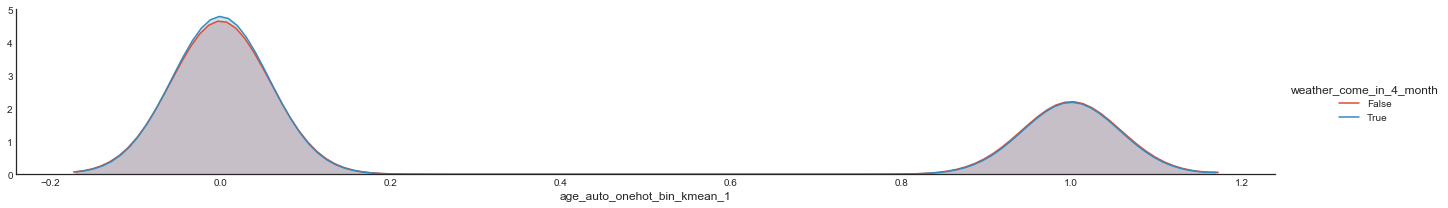

In [325]:
a = sns.FacetGrid(df, hue = 'weather_come_in_4_month', aspect = 6)
a.map(sns.kdeplot, 'age_auto_onehot_bin_kmean_1', shade = True)
#a.set(xlim= (0, df['Erstzulassungsdatum_year'].max()))
a.add_legend()

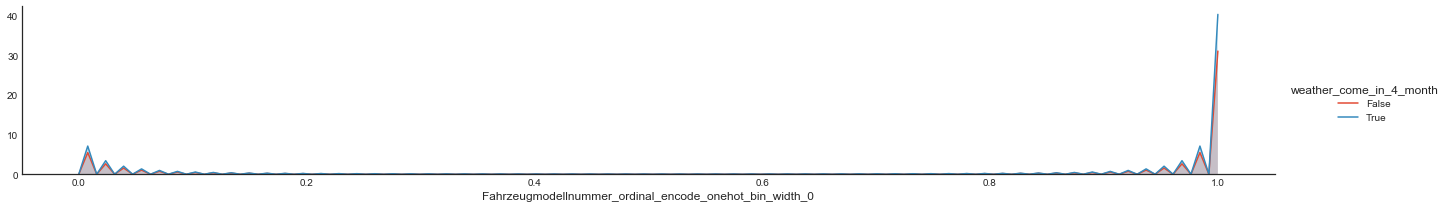

In [326]:
a = sns.FacetGrid(df, hue = 'weather_come_in_4_month', aspect = 6)
a.map(sns.kdeplot, 'Fahrzeugmodellnummer_ordinal_encode_onehot_bin_width_0', shade = True)
#a.set(xlim= (0, df['Erstzulassungsdatum_year'].max()))
a.add_legend()

In [92]:
list(df.columns)

['Auftragsnummer',
 'num_act',
 'total AW',
 'Gruppe-Nr',
 'num_teile',
 'KM-Stand',
 'Markencode',
 'Lagerortcode',
 'Auftragsdatum',
 'Adressanredecode',
 'Motorcode',
 'Fahrzeugmodellnummer',
 'Modell',
 'Typ',
 'Getriebecode',
 'Gewicht',
 'Leistung (KW)',
 'Fahrgestellnummer',
 'Erstzulassungsdatum',
 'year',
 'month',
 'day',
 'age_auto',
 'age_autohaus',
 'frequent_in_2014',
 'frequent_in_2015',
 'frequent_in_2016',
 'frequent_in_2017',
 'frequent_in_2018',
 'frequent_in_last_1_month',
 'frequent_in_last_2_month',
 'frequent_in_last_3_month',
 'frequent_in_last_4_month',
 'frequent_in_last_5_month',
 'frequent_in_last_6_month',
 'km_distance_from_last',
 'max_km_distance_in_group',
 'min_km_distance_in_group',
 'mean_km_distance_in_group',
 'mean_time_distance_in_group',
 'max_time_distance_in_group',
 'min_time_distance_in_group',
 'num_act_shift1',
 'num_act_shift2',
 'num_teile_shift1',
 'num_teile_shift2',
 'repair_age',
 'time_distance_from_last',
 'total_aw_shift1',
 'tota

In [106]:
df['age_auto'].value_counts()

362.0    506
0.0      487
363.0    481
364.0    448
359.0    415
360.0    411
361.0    393
1.0      392
355.0    388
2.0      384
4.0      384
356.0    375
5.0      375
357.0    368
9.0      366
349.0    362
354.0    348
3.0      345
10.0     342
11.0     342
358.0    341
6.0      339
15.0     318
17.0     312
347.0    311
352.0    311
7.0      307
14.0     303
13.0     303
350.0    298
        ... 
263.0    168
259.0    167
127.0    167
80.0     167
267.0    167
157.0    167
155.0    166
262.0    166
106.0    165
65.0     165
236.0    163
260.0    163
135.0    163
104.0    162
196.0    161
261.0    159
184.0    159
248.0    157
219.0    157
44.0     156
79.0     156
266.0    155
107.0    154
220.0    154
170.0    153
142.0    150
204.0    148
100.0    147
93.0     141
94.0     141
Name: age_auto, Length: 365, dtype: int64

In [55]:
#cal_entropy(test, 'Erstzulassungsdatum_year', 'weather_come_in_n_month')

Erstzulassungsdatum_year : 	Entropy: 0.983514


0.98351412258866477

In [327]:
del_index = aw[aw['AW-Nr'].map(lambda x: bool(re.search('[a-zA-Z]', str(x))))]
df['Erstzulassungsdatum']

NameError: name 'aw' is not defined

In [276]:
X_train = train[['frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month',
               'mean_km_distance_in_group',
               'trend_of_frequent_in_the_past',
               'km_distance_from_last_ordinal_encode_after_mdlp', 'time_distance_from_last_ordinal_encode_after_mdlp',
               'num_act_ordinal_encode_after_mdlp', 'total AW_ordinal_encode_after_mdlp',
               'KM-Stand_ordinal_encode_after_mdlp', 'Leistung (KW)_ordinal_encode_after_mdlp',
               'num_teile_ordinal_encode_after_mdlp']]
Y_train = train['weather_come_in_n_month']

In [277]:
true_test = test[test['weather_come_in_n_month'] == True] #4457
false_test = test[test['weather_come_in_n_month'] == False] # 5918
test = pd.concat([true_test.sample(4000), false_test.sample(4000)], axis = 0)
X_test = test[['frequent_in_last_3_month', 'frequent_in_last_4_month', 'frequent_in_last_5_month',
               'mean_km_distance_in_group',
               'trend_of_frequent_in_the_past',
               'km_distance_from_last_ordinal_encode_after_mdlp', 'time_distance_from_last_ordinal_encode_after_mdlp',
               'num_act_ordinal_encode_after_mdlp', 'total AW_ordinal_encode_after_mdlp',
               'KM-Stand_ordinal_encode_after_mdlp', 'Leistung (KW)_ordinal_encode_after_mdlp',
               'num_teile_ordinal_encode_after_mdlp']]
Y_test = test['weather_come_in_n_month']

In [279]:
# only do it for neural network training
std_scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

In [280]:
# select features
#sf = X_train[features_to_scale]
sf = X_train
# name 
name_std_scale = [f + '_std_scale' for f in features_to_scale]
# fit and transform
std_scaler.fit(sf)
tmp = std_scaler.transform(sf)
# rename
tmp = pd.DataFrame(tmp, columns = X_train.columns)
# combine
#X_train = pd.concat([X_train, tmp], axis = 1)
X_train = tmp
# del and gc
del sf, tmp
gc.collect()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


127

In [281]:
# standardization of test data
tmp = std_scaler.transform(X_test)
X_test = pd.DataFrame(tmp, columns = X_test.columns)
del tmp
gc.collect()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


0

In [291]:
#quan_scaler = QuantileTransformer()
X_train.values

array([[-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577,  1.00888404],
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [ 0.62191063,  0.41137499,  0.22936486, ...,  0.36062281,
        -0.63924577,  1.00888404],
       ..., 
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [-0.67664283, -0.74510802, -0.81091908, ...,  0.36062281,
        -0.63924577, -0.79426456],
       [ 0.62191063,  0.41137499,  0.22936486, ...,  0.36062281,
        -0.63924577, -0.79426456]])

In [285]:
# select features
#sf = sd[features_to_quantile]
# name 
#name_quan_scale = [f + 'quan_scale' for f in features_to_quantile]
# fit and transform
#quan_scaler.fit(sf)
#tmp = quan_scaler.transform(sf)
# rename
#tmp = pd.DataFrame(tmp, columns = name_quan_scale)
# combine
#sd = pd.concat([sd, tmp], axis = 1)
# del and gc
#del sf, tmp
#gc.collect()

In [286]:
#features_to_power = ['total AW']

In [287]:
#power_scaler = PowerTransformer()

In [288]:
# select features
#sf = sd[features_to_power]
# name
#name_power_scale = [f + 'power_scale' for f in features_to_power]
# fit and transform
#power_scaler.fit(sf)
#tmp = power_scaler.transform(sf)
# rename
#tmp = pd.DataFrame(tmp, columns = name_power_scale)
# combine
#sd = pd.concat([sd, tmp], axis = 1)
# del and gc
#del sf, tmp
#gc.collect()

## MLP

In [124]:
run_mlp(X_train.values, Y_train.astype(int).values, X_train.values, Y_train.astype(int).values)

NameError: name 'X_train' is not defined

## 线性方程中有a但没有b？？

## deal with data balance

In [154]:
df = df.drop('weather_come_in_4_month', axis = 1)

## feature selection and modelling

In [334]:
test['weather_come_in_4_month']

7        False
24       False
26       False
30       False
56        True
57        True
58        True
59        True
60        True
61        True
62        True
63        True
87        True
88        True
89       False
93       False
95       False
100      False
109       True
110       True
111      False
119       True
120      False
127       True
128      False
136      False
140       True
141       True
142      False
168       True
         ...  
95303     True
95304    False
95306     True
95307     True
95308     True
95314    False
95316    False
95323    False
95324     True
95325    False
95341     True
95342     True
95343     True
95344    False
95345     True
95346     True
95357     True
95358     True
95359    False
95360     True
95361    False
95390     True
95391    False
95400    False
95401     True
95402    False
95415     True
95416    False
95425    False
95432    False
Name: weather_come_in_4_month, Length: 22807, dtype: bool

In [336]:
# with entropy
for col in df.columns:
    cal_entropy(test, col, 'weather_come_in_4_month')

Adressanredecode : 	Entropy: 0.982072
Adressanredecode_are_same_in_last_11_month : 	Entropy: 0.999673
Adressanredecode_are_same_in_last_1_month : 	Entropy: 0.999713
Adressanredecode_are_same_in_last_3_month : 	Entropy: 0.999646
Adressanredecode_are_same_in_last_5_month : 	Entropy: 0.999636
Adressanredecode_are_same_in_last_7_month : 	Entropy: 0.999662
Adressanredecode_are_same_in_last_9_month : 	Entropy: 0.999694
Adressanredecode_shift1 : 	Entropy: 0.981753
Adressanredecode_shift2 : 	Entropy: 0.983893
Adressanredecode_shift3 : 	Entropy: 0.985225
Adressanredecode_shift4 : 	Entropy: 0.984449
Auftragsdatum : 	Entropy: 0.986453
Auftragsdatum_shift1 : 	Entropy: 0.944501
Auftragsnummer : 	Entropy: 0.000000
Erstzulassungsdatum : 	Entropy: 0.800503
Erstzulassungsdatum_year : 	Entropy: 0.961554
Fahrgestellnummer : 	Entropy: 0.472619
Fahrzeugmodellnummer : 	Entropy: 0.973283
Getriebecode : 	Entropy: 0.967423
Gewicht : 	Entropy: 0.997679
Gruppe-Nr : 	Entropy: 0.980534
Gruppe-Nr_shift1 : 	Entropy:

In [338]:
# with tsfresh significat test
import tsfresh

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [339]:
tag = 'weather_come_in_4_month'
alg = 'smir' # [mann, smir]
for col in list(df.columns):
    if df[col].dtype == np.float64:
        out = tsfresh.feature_selection.significance_tests.target_binary_feature_real_test(df[col], df[tag], alg)
    elif df[col].dtype == bool:
        out = tsfresh.feature_selection.significance_tests.target_binary_feature_binary_test(df[col], df[tag])
    elif df[col].dtype == np.int64:
        out = tsfresh.feature_selection.significance_tests.target_binary_feature_real_test(df[col], df[tag], alg)
    else:
        continue
    print('type: {}\t{} : \tSignificance: {:.6f}'.format(df[col].dtype, col, out))
    

type: bool	Adressanredecode_are_same_in_last_11_month : 	Significance: 0.000000
type: bool	Adressanredecode_are_same_in_last_1_month : 	Significance: 0.000001
type: bool	Adressanredecode_are_same_in_last_3_month : 	Significance: 0.000000
type: bool	Adressanredecode_are_same_in_last_5_month : 	Significance: 0.000000
type: bool	Adressanredecode_are_same_in_last_7_month : 	Significance: 0.000000
type: bool	Adressanredecode_are_same_in_last_9_month : 	Significance: 0.000000
type: int64	Erstzulassungsdatum_year : 	Significance: 0.000000
type: float64	KM-Stand : 	Significance: 0.000000
type: float64	KM-Stand_shift1 : 	Significance: 0.000000
type: float64	KM-Stand_shift2 : 	Significance: 0.000000
type: float64	KM-Stand_shift3 : 	Significance: 0.000000
type: float64	KM-Stand_shift4 : 	Significance: 0.000000
type: bool	Lagerortcode_are_same_in_last_11_month : 	Significance: 0.000000
type: bool	Lagerortcode_are_same_in_last_1_month : 	Significance: 0.000000
type: bool	Lagerortcode_are_same_in_la

ValueError: Feature time_distance_shift1 contains NaN values

In [196]:
df['weather_come_in_n_month'][df['Modell_ordinal_encode_onehot_bin_width_0'] == True].value_counts()

True     5792
False    4091
Name: weather_come_in_n_month, dtype: int64

In [167]:
for col in df.columns:
    if df[col].dtype == np.float64 and len(df[col].value_counts()) == 2:
        df[col] = df[col].astype(bool)
        print(df[col].dtype)
    print('{} \tis type of {}'.format(col, df[col].dtype))

Auftragsnummer 	is type of object
num_act 	is type of category
total AW 	is type of category
Gruppe-Nr 	is type of object
num_teile 	is type of category
KM-Stand 	is type of category
Markencode 	is type of object
Lagerortcode 	is type of object
Auftragsdatum 	is type of datetime64[ns]
Adressanredecode 	is type of object
Motorcode 	is type of object
Fahrzeugmodellnummer 	is type of object
Modell 	is type of object
Typ 	is type of object
Getriebecode 	is type of object
Gewicht 	is type of object
Leistung (KW) 	is type of category
Fahrgestellnummer 	is type of object
Erstzulassungsdatum 	is type of object
year 	is type of object
month 	is type of object
day 	is type of object
age_auto 	is type of float64
age_autohaus 	is type of int64
frequent_in_2014 	is type of int64
frequent_in_2015 	is type of int64
frequent_in_2016 	is type of int64
frequent_in_2017 	is type of int64
frequent_in_2018 	is type of int64
frequent_in_last_1_month 	is type of float64
frequent_in_last_2_month 	is type of f

In [193]:
df['total AW_onehot_bin_kmean_2'].value_counts()

False    73253
True        27
Name: total AW_onehot_bin_kmean_2, dtype: int64

In [195]:
MLA = {
    # Ensemble Methods 
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    # Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    #linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    # SVM
    #svm.SVC(probability = True),
    #svm.NuSVC(probability = True),
    svm.LinearSVC(),
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    # Descriminate Analysis
    #discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    # xgboot
    XGBClassifier()
}

In [196]:
# cross validation
# run model with 10x with 60/30 split intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean',
               'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [197]:
# index through MLA and save performance to table
MLA_predict = {}
row_index = 0
for alg in MLA:
    # set name and parameters
    MLA_name = alg.__class__.__name__
    print("#"*88)
    print(MLA_name)
    print("#"*88)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    # score model with cross validation
    cv_results = model_selection.cross_validate(alg, X_train, Y_train, cv = cv_split)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    # save MLA predictions
    alg.fit(X_train, Y_train)
    MLA_predict[MLA_name] = alg.predict(X_train)
    row_index += 1

    # sort and print
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    MLA_compare

########################################################################################
SGDClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameter

########################################################################################
AdaBoostClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
BernoulliNB
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/naive_bayes.py:948: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1

########################################################################################
Perceptron
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have

########################################################################################
RandomForestClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 i

########################################################################################
KNeighborsClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
ExtraTreesClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 i

########################################################################################
ExtraTreeClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
XGBClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
PassiveAggressiveClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning

########################################################################################
LogisticRegressionCV
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value wi

########################################################################################
GaussianNB
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
BaggingClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
DecisionTreeClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
LinearSVC
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/

########################################################################################
QuadraticDiscriminantAnalysis
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


########################################################################################
GradientBoostingClassifier
########################################################################################


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [24]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.985803,0.726996,0.00517335,1.99144
10,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.986934,0.720808,0.00568949,0.575658
9,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.718405,0.713044,0.00746942,4.06738
2,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.717246,0.711754,0.00675221,1.88304
6,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.999094,0.699386,0.00794162,0.563557
1,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.696367,0.693473,0.00456799,1.38899
12,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.999094,0.685038,0.00671227,0.354512
13,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.999094,0.639881,0.0178932,0.0970144
14,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.632421,0.63277,0.00682149,1.10849
15,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.626899,0.624721,0.0121201,0.0843212


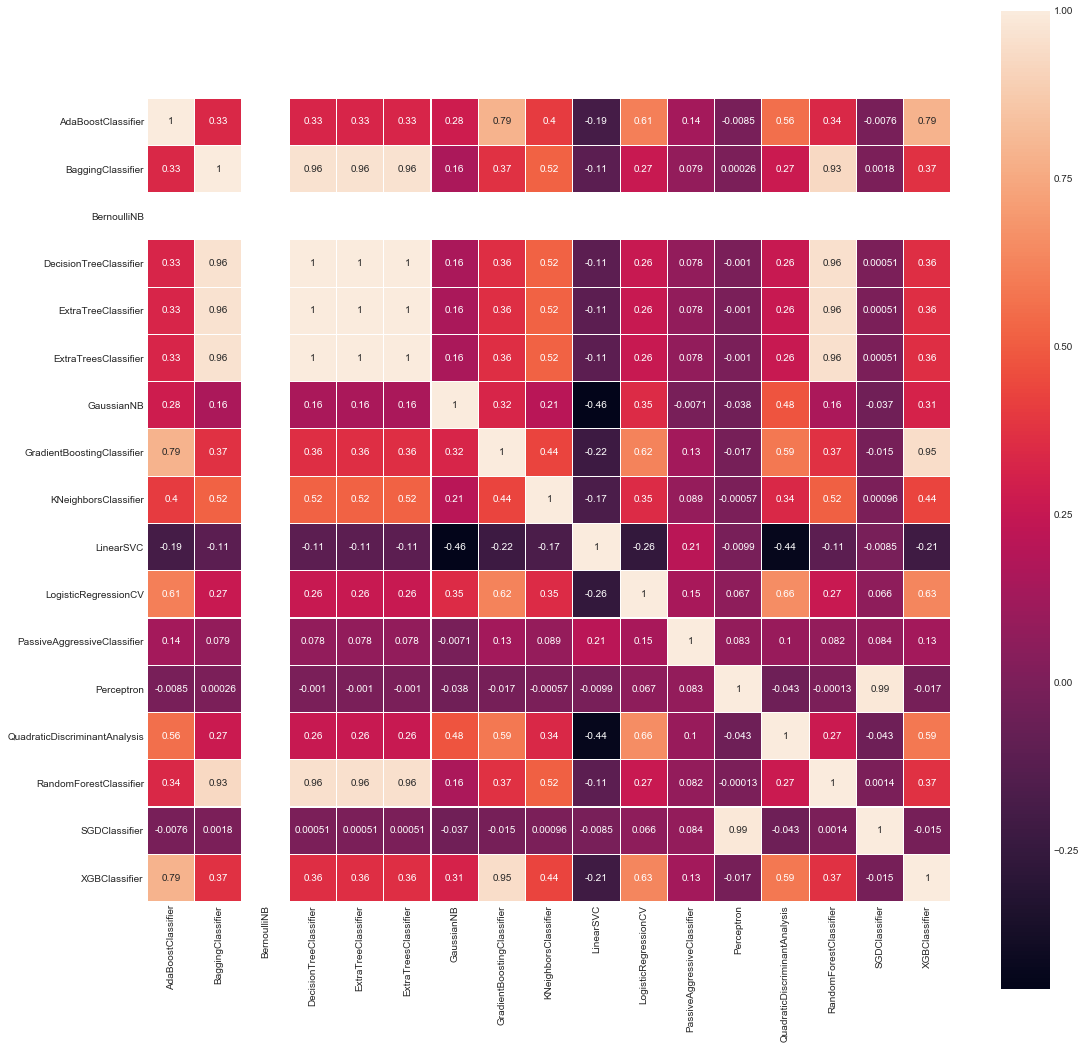

In [198]:
MLA_predict_pd = pd.DataFrame.from_dict(MLA_predict)
f, ax = plt.subplots(figsize = (18,18))
sns.heatmap(MLA_predict_pd.astype(float).corr(), 
            linewidths = 0.1, vmax = 1.0, ax = ax,
            square = True, linecolor = 'white', 
            annot = True)

In [ ]:
#  除此之外，还可以弄个rnn模型，从而，不单单考虑当前的transaction，而是考虑所有的，来得到最终结果

In [199]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gnb', naive_bayes.GaussianNB()),
    ('knn', neighbors.KNeighborsClassifier()),
    ('rf', ensemble.RandomForestClassifier()),
    ('bnb', naive_bayes.BernoulliNB()),
    ('sgd', linear_model.SGDClassifier()),
    ('pec', linear_model.Perceptron()),
    ('pac', linear_model.PassiveAggressiveClassifier()),
    ('lsvc', svm.LinearSVC())
]

In [200]:
vote_soft = ensemble.VotingClassifier(estimators = vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, Y_train, cv =cv_split)
vote_soft.fit(X_train, Y_train)
print("Soft voting Training w/bin score mean: {:.2f}".format(vote_soft_cv['train_score'].mean()*100))
print("Soft voting Test w/bin score mean: {:.2f}".format(vote_soft_cv['test_score'].mean()*100))
print("Soft voting Test w/bin score 3*std: ±{:.2f}".format(vote_soft_cv['test_score'].std()*100*3))

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.

AttributeError: probability estimates are not available for loss='hinge'

In [201]:
vote_hard = ensemble.VotingClassifier(estimators = vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, Y_train, cv = cv_split)
vote_hard.fit(X_train, Y_train)
print("Hard voting Training w/bin score mean: {:.2f}".format(vote_hard_cv['train_score'].mean()*100))
print("Hard voting Test w/bin score mean: {:.2f}".format(vote_hard_cv['test_score'].mean()*100))
print("Hard voting Test w/bin score 3*std: ±{:.2f}".format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.

Hard voting Training w/bin score mean: 88.26
Hard voting Test w/bin score mean: 65.32
Hard voting Test w/bin score 3*std: ±5.48
----------


/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [289]:
test_model(ensemble.BaggingClassifier())

0.637375


In [290]:
finetune_model_ada = finetune_gridsearch('xgbc')
test_model(ensemble.BaggingClassifier())

0.63425


In [296]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68994 entries, 0 to 68993
Data columns (total 12 columns):
frequent_in_last_3_month                             68994 non-null float64
frequent_in_last_4_month                             68994 non-null float64
frequent_in_last_5_month                             68994 non-null float64
mean_km_distance_in_group                            68994 non-null float64
trend_of_frequent_in_the_past                        68994 non-null float64
km_distance_from_last_ordinal_encode_after_mdlp      68994 non-null float64
time_distance_from_last_ordinal_encode_after_mdlp    68994 non-null float64
num_act_ordinal_encode_after_mdlp                    68994 non-null float64
total AW_ordinal_encode_after_mdlp                   68994 non-null float64
KM-Stand_ordinal_encode_after_mdlp                   68994 non-null float64
Leistung (KW)_ordinal_encode_after_mdlp              68994 non-null float64
num_teile_ordinal_encode_after_mdlp                  68

In [205]:
# test the result with test set
def test_model(model):
    #model = ensemble.BaggingClassifier()
    model.fit(X_train, Y_train)
    Y_predict = model.predict(X_test)
    result = pd.concat([Y_test.reset_index().iloc[:,1:], pd.Series(Y_predict, name = 'predict')], axis = 1)
    print(len(result[result['weather_come_in_n_month'] == result['predict']])/len(result))

# CODE 

In [335]:
def cal_entropy(df, feature, target):
    """
    input:
      df pd.DataFrame
      feature String
        name of the feature
      target String
        name of the target
    """
    if feature == target:
        return 1
    ce = df[[feature, target]]
    len_df = len(df)
    lengths = []
    entropys = []
    for name, group in ce.groupby(feature, as_index = False):
        len_group = len(group)
        dis_group = list(group[target].value_counts())
        dis_group = [1.0*d/len_group for d in dis_group]
        en_group = scipy.stats.entropy(dis_group, base = 2)
        lengths.append(len_group)
        entropys.append(en_group)
    ratios = [1.0*l/len_df for l in lengths]
    info = sum([r*e for r, e in zip(ratios, entropys)])
    print('{} : \tEntropy: {:.6f}'.format(feature, info))
    return info


In [5]:
# MLP
# to use the classification model, you should change the codes in following position:
#   1. model = TS_mlp(12)
#   2. loss = torch.nn.CrossEntropyLoss()
#   3. train = CData(train_x, train_y)
#   4. test = CData(train_x, train_y)
#   5. test_loss, test_rate = test_model(dl_test, model, loss)
def run_mlp(train_x, train_y, test_x, test_y, b_s = 100, epochs = 100, verbose = True):
    """
    input:
      train_x, type of np array
        features of the training set
      train_y, type of np array
        target of the training set
      test_x, type of np array
        features of the testing set
      test_y, type of np array
        target of the testing set
    """
    # set models and loss
    model = TS_mlp2(12)
    #loss = torch.nn.CrossEntropyLoss()
    loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
    # set the scheduler
    lamb1 = lambda x: .1**(x//25)
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
    # loda data
    train = RData(train_x, train_y)
    test = RData(test_x, test_y)
    dl_train = DataLoader(train, batch_size = b_s, shuffle = True)
    dl_test = DataLoader(test, batch_size = b_s, shuffle = True)
    # train the model
    num_epochs = epochs
    for epoch in range(num_epochs):
        scheduler.step()
        model.train()
        train_loss = 0
        counter = 0
        for batch_idx, dat in enumerate(dl_train):
            counter += 1
            # train the model
            optimizer.zero_grad()
            inp, target = dat
            out = model(inp)
            lo = loss(out, target)
            lo.backward()
            optimizer.step()
            train_loss += lo.data
            if verbose:
                if batch_idx % 10 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch,
                        batch_idx * b_s,
                        len(train),
                        100.*batch_idx*b_s/len(train),
                        lo.data
                        ))
        test_lo, test_rate = test_model2(dl_test, model, loss)
        if verbose:
            # train loss
            print('====> Epoch: {} Average train loss: {:.4f}'.format(
                epoch,
                train_loss/counter
                ))
            # test loss
            print('====> Epoch: {} Average test loss: {:.4f} Average hit rate: {:.4f}'.format(
                epoch,
                test_lo,
                test_rate
                ))

#####################
# assist function
####################
class CData:
    def __init__(self, x, y):
        """
        input:
            x: np array
              training features
            y: np array
              training target
        """
        self.data = {}
        self.data['train_x'] = torch.from_numpy(x).type(torch.FloatTensor)
        self.data['train_y'] = torch.from_numpy(y).type(torch.LongTensor)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])
    
class RData:
    def __init__(self, x, y):
        """
        input:
            x: np array
              training features
            y: np array
              training target
        """
        self.data = {}
        self.data['train_x'] = torch.from_numpy(x).type(torch.FloatTensor)
        self.data['train_y'] = torch.from_numpy(y).type(torch.FloatTensor)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

def test_model(dl_test, model, loss):
    """
    for classificator
    """
    model.eval()
    test_loss = 0
    test_rate = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        #TODO codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        rate = (out.max(dim = 1)[1] == target).sum()
        test_loss += lo.data
        test_rate += rate
    test_rate = 1.0*test_rate/len(dl_test)
    return test_loss/counter, test_rate

def test_model2(dl_test, model, loss):
    """
    for regression
    """
    model.eval()
    test_loss = 0
    test_rate = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        #TODO codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        rate = (out.round() == target).sum()
        test_loss += lo.data
        test_rate += rate
    test_rate = 1.0*test_rate/len(dl_test)
    return test_loss/counter, test_rate
########################
## model
########################
class TS_mlp(torch.nn.Module):
    def __init__(self, dim_input = 7):
        super(TS_mlp, self).__init__()
        num_hidden = 128
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(dim_input, num_hidden),
                #torch.nn.Dropout(),
                torch.nn.BatchNorm1d(128),
                torch.nn.ReLU(),
                torch.nn.Linear(num_hidden, 2),
                )
    
    def forward(self, inp):
        out = self.mlp(inp)
        return out.squeeze()
class TS_mlp2(torch.nn.Module):
    def __init__(self, dim_input = 7):
        super(TS_mlp2, self).__init__()
        num_hidden = 128
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(dim_input, num_hidden),
                #torch.nn.Dropout(),
                torch.nn.BatchNorm1d(num_hidden),
                torch.nn.ReLU(),
                torch.nn.Linear(num_hidden, 32),
                torch.nn.BatchNorm1d(32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 1),
                )
    
    def forward(self, inp):
        out = self.mlp(inp)
        return out.squeeze()

In [6]:
# finetune
def _get_param_grid_and_model_for_gridsearch(model = 'ada'):
    """
    input:
        model: type of model
    output:
        param_grid, type of dict
        mod: MLA model 
    """
    grid_n_estimator = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    grid_ratio = [.1, .25, .5, .75, 1.0]
    grid_learn = [.01, .03, .05, .1, .25]
    grid_max_depth = [2, 4, 6, 8, 10, None]
    grid_min_samples = [5, 10, .03, .05, .01]
    grid_criterion = ['gini', 'entropy']
    grid_bool = [True, False]
    grid_seed = [0]
    if model == 'adaBoost':
        grid_param = {
#                'base_estimator__criterion': ['gini', 'entropy'],
#                'base_estimator__splitter': ['best', 'random'],
                'n_estimators': grid_n_estimator, # default = 50
                'learning_rate': grid_learn, # default = 1
                'algorithm': ['SAMME', 'SAMME.R'], # default = 'SAMME.R'
                'random_state': grid_seed
                }
        mod = ensemble.AdaBoostClassifier()
    elif model == 'bagging':
        grid_param = {
                'n_estimators': grid_n_estimator, # default = 10
                'max_samples': grid_ratio, # default = 1.0
                'random_state': grid_seed
                }
        mod = ensemble.BaggingClassifier()
    elif model == 'extraTrees':
        grid_param = {
                'n_estimators': grid_n_estimator, # default  = 10
                'criterion': grid_criterion, # default = 'gini'
                'max_depth': grid_max_depth, # default = None
                'max_features': [1, 3, 7],
                'min_samples_split': [2, 3, 7],
                'min_samples_leaf': [1, 3, 7],
                'bootstrap': [False],
                'random_state': grid_seed
                }
        mod = ensemble.ExtraTreesClassifier()
    elif model == 'gradientBoosting':
        grid_param = {
                'loss': ['deviance', 'exponential'], # default = 'deviance'
                'learning_rate': [.1, .05, .01], # default = 0.1
                'n_estimators': [300], # default = 100
                'criterion': ['friedman_mse', 'mse', 'mae'], # default = 'friedman_mse'
                'max_depth': grid_max_depth, # default = 3
                'min_samples_leaf': [100,150],
                'max_features': [.3, .1],
                'random_state': grid_seed
                }
        mod = ensemble.GradientBoostingClassifier()
    elif model == 'randomForest':
        grid_param = {
                'n_estimators': grid_n_estimator, # default = 0
                'criterion': grid_criterion, # default = 'gini'
                'max_depth': grid_max_depth, # default = None
                'oob_score': [True], # default = False
                'random_state': grid_seed,
                'min_samples_split': [2, 3, 7],
                'min_samples_leaf': [1, 3, 7],
                }
        mod = ensemble.RandomForestClassifier()
    elif model == 'gaussianProcess':
        grid_param = {
                'max_iter_predict': grid_n_estimator, # default = 100
                'random_state': grid_seed
                }
        mod = gaussian_process.GaussianProcessClassifier()
    elif model == 'decisionTree':
        param_grid = {
                'criterion': ['gini', 'entropy'], # default gini
                'splitter': ['best', 'random'], # default best
                'max_depth': [2, 4, 6, 8, 10, None], # default None
                'min_samples_split': [2, 5, 10, .03, .05], # minimum subset size before new split, default 2
                'min_samples_lear': [1, 5, 10, .03, .05], # minimum subset size after new split, default 1
                'max_features': [None, 'auto'], # max features to consider when performing split; default noen or all
                'random_state': [0] # seed or control random number generator
                }
        mod = tree.DecisionTreeClassifier()
    elif model == 'logisticRegression':
        grid_param = {
                'fit_intercept': grid_bool, # default = True
                #'penalty': ['11', '12'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # default: lbfgs
                'random_state': grid_seed
                }
        mod = linear_model.LogisticRegressionCV() # ??
    elif model == 'bernoulliNB':
        grid_param = {
                'alpha': grid_ratio, # default1.0
                }
        mod = naive_bayes.BernoulliNB()
    elif model == 'kNeighbors':
        grid_param = {
                'n_neighbors': [1, 2, 3, 4, 5, 6, 7], # default = 5
                'weights': ['uniform', 'distance'], #default = 'uniform'
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                }
        mod = neighbors.KNeighborsClassifier()
    elif model == 'svc':
        grid_param = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [1, 5, 10, 50, 100, 200, 300, 1000], # default = 1.0
                'gamma': grid_ratio, # default = auto
                'decision_function_shape': ['ovo', 'ovr'], # default = ovr
                'probability': [True],
                'random_state': grid_seed
                }
        mod = svm.SVC(probability = True)
    elif model == 'xgbc':
        grid_param = {
                'learning_rate': grid_learn, # default = .3
                'max_depth': [1, 2, 4, 6, 8, 10], # default = 2
                'n_estimators': grid_n_estimator,
                'seed': grid_seed
                }
        mod = XGBClassifier()
    else:
        print('unrecognized model: '+ model)
    return grid_param, mod
def finetune_gridsearch(model = 'adaBoost'):
    """
    ada: AdaBoostClassifier
    """
    param_grid, mod = _get_param_grid_and_model_for_gridsearch(model)
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0)
    tune_model = model_selection.GridSearchCV(mod, param_grid = param_grid, scoring = 'roc_auc', cv = cv_split)
    return tune_model

In [7]:
def check_to_1(df, atta, attb):
    """
    input:
        df, Dataframe:
            the data frame
        atta, string:
            first attribute
        attb, string:
            second attribute
    output:
        out boolean:
            if for an a has more than one b, return True, otherwise return False
    """
    df = df[[atta, attb]]
    df.to_csv('/tmp/tmp.csv', sep = ';', index = False)
    abdict = ABDict('/tmp/tmp.csv', header = True, sep = ';')
    dic = abdict.dic
    flag = 0
    for i,j in dic.items():
        if len(j) > 1:
            print(str(i) + '\t' + str(j))

In [8]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [9]:
class ABDict:
    """
    make sure that only two columns in the df, otherwise only the first two columns will be used
    用于两列数据互补空值
    """
    def __init__(self, path, header = True, sep = ';'):
        self.dic = self._load_dict(path, header, sep) 
        self.dic_conv = self._load_dict_conv(path, header, sep)
        print(len(self.dic))
        print(len(self.dic_conv))
        counter = 0
        ########
        # test #
        ########
        #for i in self.dic.keys():
        #    if counter > 1:
        #        break
        #    print(i, self.dic[i])
        #    counter += 1
        #print('schraube' in self.dic_conv.keys())
    
    def AToB(self, a):
        if a in self.dic.keys():
            out = self.dic[a][0]
            if type(out) == list:
                print(out)
            return out
        else:
            #print(a)
            return float('nan')
    
    def BToA(self, b):
        if b in self.dic_conv.keys():
            out = self.dic_conv[b][0]
            #print(out)
            return out
        else:
            #print(b)
            return float('nan')

    def _load_dict(self, path, header, sep):
        dic = {} 
        with open(path) as fi:
            counter = 0
            for li in fi:
                if header and counter ==0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()   # 忘记去换行符了，导致调了一晚上的错
                items = li.split(sep)
                if items[0] not in dic.keys():
                    # if not exit, add new item
                    if items[1] != 'nan':
                        dic[items[0]] = [items[1]]
                elif items[1] not in dic[items[0]]:
                    # if item exit but value not eixt, add the value to the list
                    dic[items[0]].append(items[1])
                counter += 1
        return dic
    
    def _load_dict_conv(self, path, header, sep):
        dic = {}
        with open(path) as fi:
            counter = 0
            for li in fi:
                if header and counter == 0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()
                items = li.split(sep)
                if items[1] not in dic.keys():
                    if items[0] != 'nan':
                        #print(items[0])
                        dic[items[1]] = [items[0]]
                elif items[0] not in dic[items[1]]:
                    dic[items[1]].append(items[0])
                counter += 1
        return dic

In [10]:
import pandas as pd
import numpy as np
from math import log
import random


def entropy(data_classes, base=2):
    '''
    Computes the entropy of a set of labels (class instantiations)
    :param base: logarithm base for computation
    :param data_classes: Series with labels of examples in a dataset
    :return: value of entropy
    '''
    if not isinstance(data_classes, pd.core.series.Series):
        raise AttributeError('input array should be a pandas series')
    classes = data_classes.unique()
    N = len(data_classes)
    ent = 0  # initialize entropy

    # iterate over classes
    for c in classes:
        partition = data_classes[data_classes == c]  # data with class = c
        proportion = len(partition) / N
        #update entropy
        ent -= proportion * log(proportion, base)

    return ent

def cut_point_information_gain(dataset, cut_point, feature_label, class_label):
    '''
    Return de information gain obtained by splitting a numeric attribute in two according to cut_point
    :param dataset: pandas dataframe with a column for attribute values and a column for class
    :param cut_point: threshold at which to partition the numeric attribute
    :param feature_label: column label of the numeric attribute values in data
    :param class_label: column label of the array of instance classes
    :return: information gain of partition obtained by threshold cut_point
    '''
    if not isinstance(dataset, pd.core.frame.DataFrame):
        raise AttributeError('input dataset should be a pandas data frame')

    entropy_full = entropy(dataset[class_label])  # compute entropy of full dataset (w/o split)

    #split data at cut_point
    data_left = dataset[dataset[feature_label] <= cut_point]
    data_right = dataset[dataset[feature_label] > cut_point]
    (N, N_left, N_right) = (len(dataset), len(data_left), len(data_right))

    gain = entropy_full - (N_left / N) * entropy(data_left[class_label]) - \
        (N_right / N) * entropy(data_right[class_label])

    return gain

In [11]:
from __future__ import division
__author__ = 'Victor Ruiz, vmr11@pitt.edu'
import pandas as pd
import numpy as np
from math import log
import sys
import getopt
import re

class MDLP_Discretizer(object):
    def __init__(self, dataset, class_label, out_path_data=None, out_path_bins=None, features=None):
        '''
        initializes discretizer object:
            saves raw copy of data and creates self._data with only features to discretize and class
            computes initial entropy (before any splitting)
            self._features = features to be discretized
            self._classes = unique classes in raw_data
            self._class_name = label of class in pandas dataframe
            self._data = partition of data with only features of interest and class
            self._cuts = dictionary with cut points for each feature
        :param dataset: pandas dataframe with data to discretize
        :param class_label: name of the column containing class in input dataframe
        :param features: if !None, features that the user wants to discretize specifically
        :return:
        '''

        if not isinstance(dataset, pd.core.frame.DataFrame):  # class needs a pandas dataframe
            raise AttributeError('input dataset should be a pandas data frame')

        self._data_raw = dataset #copy or original input data

        self._class_name = class_label

        self._classes = self._data_raw[self._class_name] #.unique()
        self._classes.drop_duplicates()


        #if user specifies which attributes to discretize
        if features:
            self._features = [f for f in features if f in self._data_raw.columns]  # check if features in dataframe
            missing = set(features) - set(self._features)  # specified columns not in dataframe
            if missing:
                print('WARNING: user-specified features %s not in input dataframe' % str(missing))
        else:  # then we need to recognize which features are numeric
            numeric_cols = self._data_raw._data.get_numeric_data().items
            self._features = [f for f in numeric_cols if f != class_label]
        #other features that won't be discretized
        self._ignored_features = set(self._data_raw.columns) - set(self._features)

        #create copy of data only including features to discretize and class
        self._data = self._data_raw.loc[:, self._features + [class_label]]
        self._data = self._data.convert_objects(convert_numeric=True)
        #pre-compute all boundary points in dataset
        self._boundaries = self.compute_boundary_points_all_features()
        #initialize feature bins with empty arrays
        self._cuts = {f: [] for f in self._features}
        #get cuts for all features
        self.all_features_accepted_cutpoints()
        #discretize self._data
        #self.apply_cutpoints(out_data_path=out_path_data, out_bins_path=out_path_bins)

    def MDLPC_criterion(self, data, feature, cut_point):
        '''
        Determines whether a partition is accepted according to the MDLPC criterion
        :param feature: feature of interest
        :param cut_point: proposed cut_point
        :param partition_index: index of the sample (dataframe partition) in the interval of interest
        :return: True/False, whether to accept the partition
        '''
        #get dataframe only with desired attribute and class columns, and split by cut_point
        data_partition = data.copy(deep=True)
        data_left = data_partition[data_partition[feature] <= cut_point]
        data_right = data_partition[data_partition[feature] > cut_point]

        #compute information gain obtained when splitting data at cut_point
        cut_point_gain = cut_point_information_gain(dataset=data_partition, cut_point=cut_point,
                                                    feature_label=feature, class_label=self._class_name)
        #compute delta term in MDLPC criterion
        N = len(data_partition) # number of examples in current partition
        partition_entropy = entropy(data_partition[self._class_name])
        k = len(data_partition[self._class_name].unique())
        k_left = len(data_left[self._class_name].unique())
        k_right = len(data_right[self._class_name].unique())
        entropy_left = entropy(data_left[self._class_name])  # entropy of partition
        entropy_right = entropy(data_right[self._class_name])
        delta = log(3 ** k, 2) - (k * partition_entropy) + (k_left * entropy_left) + (k_right * entropy_right)

        #to split or not to split
        gain_threshold = (log(N - 1, 2) + delta) / N

        if cut_point_gain > gain_threshold:
            return True
        else:
            return False

    def feature_boundary_points(self, data, feature):
        '''
        Given an attribute, find all potential cut_points (boundary points)
        :param feature: feature of interest
        :param partition_index: indices of rows for which feature value falls whithin interval of interest
        :return: array with potential cut_points
        '''
        #get dataframe with only rows of interest, and feature and class columns
        data_partition = data.copy(deep=True)
        data_partition.sort_values(feature, ascending=True, inplace=True)

        boundary_points = []

        #add temporary columns
        data_partition['class_offset'] = data_partition[self._class_name].shift(1)  # column where first value is now second, and so forth
        data_partition['feature_offset'] = data_partition[feature].shift(1)  # column where first value is now second, and so forth
        data_partition['feature_change'] = (data_partition[feature] != data_partition['feature_offset'])
        data_partition['mid_points'] = data_partition.loc[:, [feature, 'feature_offset']].mean(axis=1)

        potential_cuts = data_partition[data_partition['feature_change'] == True].index[1:]
        sorted_index = data_partition.index.tolist()

        for row in potential_cuts:
            old_value = data_partition.loc[sorted_index[sorted_index.index(row) - 1]][feature]
            new_value = data_partition.loc[row][feature]
            old_classes = data_partition[data_partition[feature] == old_value][self._class_name].unique()
            new_classes = data_partition[data_partition[feature] == new_value][self._class_name].unique()
            if len(set.union(set(old_classes), set(new_classes))) > 1:
                boundary_points += [data_partition.loc[row]['mid_points']]

        return set(boundary_points)

    def compute_boundary_points_all_features(self):
        '''
        Computes all possible boundary points for each attribute in self._features (features to discretize)
        :return:
        '''
        boundaries = {}
        for attr in self._features:
            data_partition = self._data.loc[:, [attr, self._class_name]]
            boundaries[attr] = self.feature_boundary_points(data=data_partition, feature=attr)
        return boundaries

    def boundaries_in_partition(self, data, feature):
        '''
        From the collection of all cut points for all features, find cut points that fall within a feature-partition's
        attribute-values' range
        :param data: data partition (pandas dataframe)
        :param feature: attribute of interest
        :return: points within feature's range
        '''
        range_min, range_max = (data[feature].min(), data[feature].max())
        return set([x for x in self._boundaries[feature] if (x > range_min) and (x < range_max)])

    def best_cut_point(self, data, feature):
        '''
        Selects the best cut point for a feature in a data partition based on information gain
        :param data: data partition (pandas dataframe)
        :param feature: target attribute
        :return: value of cut point with highest information gain (if many, picks first). None if no candidates
        '''
        candidates = self.boundaries_in_partition(data=data, feature=feature)
        # candidates = self.feature_boundary_points(data=data, feature=feature)
        if not candidates:
            return None
        gains = [(cut, cut_point_information_gain(dataset=data, cut_point=cut, feature_label=feature,
                                                  class_label=self._class_name)) for cut in candidates]
        gains = sorted(gains, key=lambda x: x[1], reverse=True)

        return gains[0][0] #return cut point

    def single_feature_accepted_cutpoints(self, feature, partition_index=pd.DataFrame().index):
        '''
        Computes the cuts for binning a feature according to the MDLP criterion
        :param feature: attribute of interest
        :param partition_index: index of examples in data partition for which cuts are required
        :return: list of cuts for binning feature in partition covered by partition_index
        '''
        if partition_index.size == 0:
            partition_index = self._data.index  # if not specified, full sample to be considered for partition

        data_partition = self._data.loc[partition_index, [feature, self._class_name]]

        #exclude missing data:
        if data_partition[feature].isnull().values.any:
            data_partition = data_partition[~data_partition[feature].isnull()]

        #stop if constant or null feature values
        if len(data_partition[feature].unique()) < 2:
            return
        #determine whether to cut and where
        cut_candidate = self.best_cut_point(data=data_partition, feature=feature)
        if cut_candidate == None:
            return
        decision = self.MDLPC_criterion(data=data_partition, feature=feature, cut_point=cut_candidate)

        #apply decision
        if not decision:
            return  # if partition wasn't accepted, there's nothing else to do
        if decision:
            # try:
            #now we have two new partitions that need to be examined
            left_partition = data_partition[data_partition[feature] <= cut_candidate]
            right_partition = data_partition[data_partition[feature] > cut_candidate]
            if left_partition.empty or right_partition.empty:
                return #extreme point selected, don't partition
            self._cuts[feature] += [cut_candidate]  # accept partition
            self.single_feature_accepted_cutpoints(feature=feature, partition_index=left_partition.index)
            self.single_feature_accepted_cutpoints(feature=feature, partition_index=right_partition.index)
            #order cutpoints in ascending order
            self._cuts[feature] = sorted(self._cuts[feature])
            return

    def all_features_accepted_cutpoints(self):
        '''
        Computes cut points for all numeric features (the ones in self._features)
        :return:
        '''
        for attr in self._features:
            self.single_feature_accepted_cutpoints(feature=attr)
        return

    def apply_cutpoints(self, out_data_path=None, out_bins_path=None):
        '''
        Discretizes data by applying bins according to self._cuts. Saves a new, discretized file, and a description of
        the bins
        :param out_data_path: path to save discretized data
        :param out_bins_path: path to save bins description
        :return:
        '''
        bin_label_collection = {}
        for attr in self._features:
            if len(self._cuts[attr]) == 0:
                self._data[attr] = 'All'
                bin_label_collection[attr] = ['All']
            else:
                cuts = [-np.inf] + self._cuts[attr] + [np.inf]
                start_bin_indices = range(0, len(cuts) - 1)
                bin_labels = ['%s_to_%s' % (str(cuts[i]), str(cuts[i+1])) for i in start_bin_indices]
                bin_label_collection[attr] = bin_labels
                self._data[attr] = pd.cut(x=self._data[attr].values, bins=cuts, right=False, labels=bin_labels,
                                          precision=6, include_lowest=True)

        #reconstitute full data, now discretized
        if self._ignored_features:
            to_return = pd.concat([self._data, self._data_raw[list(self._ignored_features)]], axis=1)
            to_return = to_return[self._data_raw.columns] #sort columns so they have the original order
        else:
            to_return = self._data
        
        return to_return
    
        #save data as csv
        if out_data_path:
            to_return.to_csv(out_data_path)
        #save bins description
        if out_bins_path:
            with open(out_bins_path, 'w') as bins_file:
                print>>bins_file, 'Description of bins in file: %s' % out_data_path
                for attr in self._features:
                    print>>bins_file, 'attr: %s\n\t%s' % (attr, ', '.join([bin_label for bin_label in bin_label_collection[attr]]))

